In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
tqdm.pandas()
import matplotlib.pyplot as plt
%matplotlib inline

import os, gc, json
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sns.set(context='notebook', style='whitegrid', 
        palette='deep', font='sans-serif', 
        font_scale=2, color_codes=True, rc=None)

In [2]:
train = pd.read_csv('Dataset/train.csv')
test  = pd.read_csv('Dataset/test.csv')
sub   = pd.read_csv('Dataset/Sample_Submission.csv')

train.shape, test.shape, sub.shape

((5959, 3), (2553, 2), (5, 3))

In [3]:
train.rename(columns={'Review Text':'text', 'Review Title':'title'}, inplace=True)
test.rename(columns={'Review Text':'text', 'Review Title':'title'}, inplace=True)
test.columns, train.columns

(Index(['text', 'title'], dtype='object'),
 Index(['text', 'title', 'topic'], dtype='object'))

In [4]:
df = train.append(test, ignore_index=True)
df['text']  = df['text'].str.lower()
df['title'] = df['title'].str.lower()

In [5]:
with open('contraction_mapping.txt') as f:
    contraction_mapping = json.loads(f.read())

In [6]:
def correct_contraction(x, dic):
    for word in dic.keys():
        if word in x:
            x = x.replace(word, dic[word])
    return x

df['text']  = df['text'].progress_apply(lambda x: correct_contraction(x, contraction_mapping))
df['title'] = df['title'].progress_apply(lambda x: correct_contraction(x, contraction_mapping))


100%|██████████| 8512/8512 [00:00<00:00, 180332.74it/s]


In [13]:
with open('punctuation.txt', 'r') as f:
    extra_punct = json.loads(f.read())


In [14]:
import os,operator


import string
my_punct = list(string.punctuation)
all_punct = list(set(my_punct + extra_punct))

special_punc_mappings = {"—": "-", "–": "-", "_": "-", '”': '"', "″": '"', '“': '"', '•': '.', '−': '-',
                         "’": "'", "‘": "'", "´": "'", "`": "'", '\u200b': ' ', '\xa0': ' ','،':'','„':'',
                         '…': ' ... ', '\ufeff': ''}

def spacing_punctuation(text):
    """
    add space before and after punctuation and symbols
    """
    for punc in all_punct:
        if punc in text:
            text = text.replace(punc, f' {punc} ')
    return text

def clean_special_punctuations(text):
    for punc in special_punc_mappings:
        if punc in text:
#             print(punc)
            text = text.replace(punc, special_punc_mappings[punc])
    return text



def preprocess(text):
    text = spacing_punctuation(text)
    text = clean_special_punctuations(text)
    return text


df["text"] = df["text"].progress_apply(preprocess)
df['text'] = df['text'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')
df['text'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
df['text'].replace({'  ':' '}, regex=True, inplace=True)

df["title"] = df["title"].progress_apply(preprocess)
df['title'] = df['title'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')
df['title'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
df['title'].replace({'  ':' '}, regex=True, inplace=True)


100%|██████████| 8512/8512 [00:00<00:00, 159383.55it/s]


In [15]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[a-zA-Z0-9_]+', '', text)   
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)   
    text = re.sub(r'www.[^ ]+', '', text)  
    text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9]*com[a-zA-Z0-9]*', '', text)  
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = [token for token in text.split() if len(token) > 2]
    text = ' '.join(text)
    return text

df['text']   = df['text'].progress_apply(clean_text)
df['title']  = df['title'].progress_apply(clean_text)

100%|██████████| 8512/8512 [00:00<00:00, 112045.73it/s]


In [16]:
def clean_text(x):
    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

df['text'] = df['text'].progress_apply(clean_text)
df['title'] = df['title'].progress_apply(clean_text)


100%|██████████| 8512/8512 [00:00<00:00, 141367.97it/s]


In [25]:
word_dict = {}
for sent in df['title']:
    for word in sent.split(" "):
        if word in word_dict:
            word_dict[word] += 1
        else:
            word_dict[word] = 1

In [27]:
len(word_dict)

2831

In [17]:
# sorted(word_dict.items(), key=lambda x: x[1], reverse=True)

In [47]:
# word_freq = pd.DataFrame.from_dict(word_dict, orient='index')

# word_freq = word_freq.reset_index()
# word_freq.columns = ['word','freq']
# word_freq.head()

,word,freq
0,useless,25
1,trash,15
2,not,2041
3,buy,255
4,these,142


In [19]:
train['topic'] = train['topic'].apply(lambda x: "_".join(x.split(" ")))
gp = train.groupby(['text','title']).agg({
        "topic": lambda x: " ".join(x.values)
    })
train1 = pd.DataFrame(gp.reset_index())
train1.head()

,text,title,topic
0,!!!!!!--->>300 mg of sodium per 1 scoop servin...,Way too much sodium per serving,Shipment_and_delivery
1,"""Is it really true that ""Garden of Life sold o...",SOLD OUT TO NESTLE AND REFUSES TO CORRECT THE ...,Ingredients Bad_Taste/Flavor Allergic
2,"""X Brand"" Brand Revly Vegan Prenatal multivita...",Contraindications about excessive folic acid i...,Quality/Contaminated Not_Effective Ingredients
3,"""X Brand"" said the package was handed to the r...",Package has not been delivered. Need the packa...,Shipment_and_delivery
4,"""X Brand"" says ""Package was left inside the re...",Never received the item.,Shipment_and_delivery


In [27]:
test['topic'] = 'null'
gp = test.groupby(['text','title']).agg({
        "topic": lambda x: " ".join(x.values)
    })
test1 = pd.DataFrame(gp.reset_index())
test1.head()

,text,title,topic
0,"""Stir for 30 seconds until product dissolves.""...",Does Not Dissolve,null
1,"""X Brand"" has failed to deliver what they offe...","The 3-pack does not come with 3, only 1.",null null
2,"""X Brand"" is screwing products. They sent hydr...",Screwed up,null null null
3,"""X Brand"" needs to make sure the top is sealed...",Shipping Issues,null
4,*I bought this when I thought I ran out. I re...,Too expensive for the strength.,null


In [35]:
print("Old table : ", df.shape, train.shape, test.shape) 
print("New Table : ", df1.shape, train1.shape, test1.shape)

Old table :  (8512, 3) (5959, 4) (2553, 3)
New Table :  (5993, 3) (4217, 3) (1776, 3)


In [29]:
df1 = train1.append(test1, ignore_index=True)
df1.shape

(5993, 3)

In [31]:
labels = train1['topic'].values

train['target'] = train['topic'].astype('category').cat.codes
train['target'] = train['target'].astype('int')

def get_mapping(df, col_name):
    cat_codes = df[col_name].astype('category')
    
    class_mapping = {}
    i = 0
    for col in cat_codes.cat.categories:
        class_mapping[col] = i
        i += 1
    
    class_mapping_reverse = {}
    for key, value in class_mapping.items():
        class_mapping_reverse[value] = key

    return class_mapping, class_mapping_reverse

cl_map, cl_map_inv = get_mapping(train, 'topic')

In [32]:
cl_map

{'Allergic': 0,
 'Bad_Taste/Flavor': 1,
 'Color_and_texture': 2,
 'Customer_Issues': 3,
 'Customer_Service': 4,
 "Didn't_Like": 5,
 'Expiry': 6,
 'False_Advertisement': 7,
 'Hard_to_Chew': 8,
 'Inferior_to_competitors': 9,
 'Ingredients': 10,
 'Not_Effective': 11,
 'Packaging': 12,
 'Pricing': 13,
 'Quality/Contaminated': 14,
 'Shipment_and_delivery': 15,
 'Smells_Bad': 16,
 'Texture': 17,
 'Too_Sweet': 18,
 'Too_big_to_swallow': 19,
 'Wrong_Product_received': 20}

In [33]:
lt = np.zeros((df1.shape[0], 21))
j = -1
for key, value in cl_map.items():
    j += 1
    for i, label in enumerate(labels):
        if key in label.split(" "):
            lt[i][j] = 1

print(lt.sum(axis=0))        

[ 567. 1193.  233.    8.  239.   31.  135.   37.    6.   44.  215.  610.
  466.  107.  712.  388.  123.  410.   97.  228.   99.]


In [36]:
l_table = pd.DataFrame(data=lt, columns=list(cl_map.keys()))
l_table = l_table.astype('int')
print(l_table.shape)
l_table.head()

(5993, 21)


,Allergic,Bad_Taste/Flavor,Color_and_texture,Customer_Issues,Customer_Service,Didn't_Like,Expiry,False_Advertisement,Hard_to_Chew,Inferior_to_competitors,Ingredients,Not_Effective,Packaging,Pricing,Quality/Contaminated,Shipment_and_delivery,Smells_Bad,Texture,Too_Sweet,Too_big_to_swallow,Wrong_Product_received
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


class count:  [1776 2914  959  277   53   11    3]
class wise:   [ 567 1194  234    8  239   31  136   37    6   44  216  611  467  107
  715  390  123  410   97  228   99]


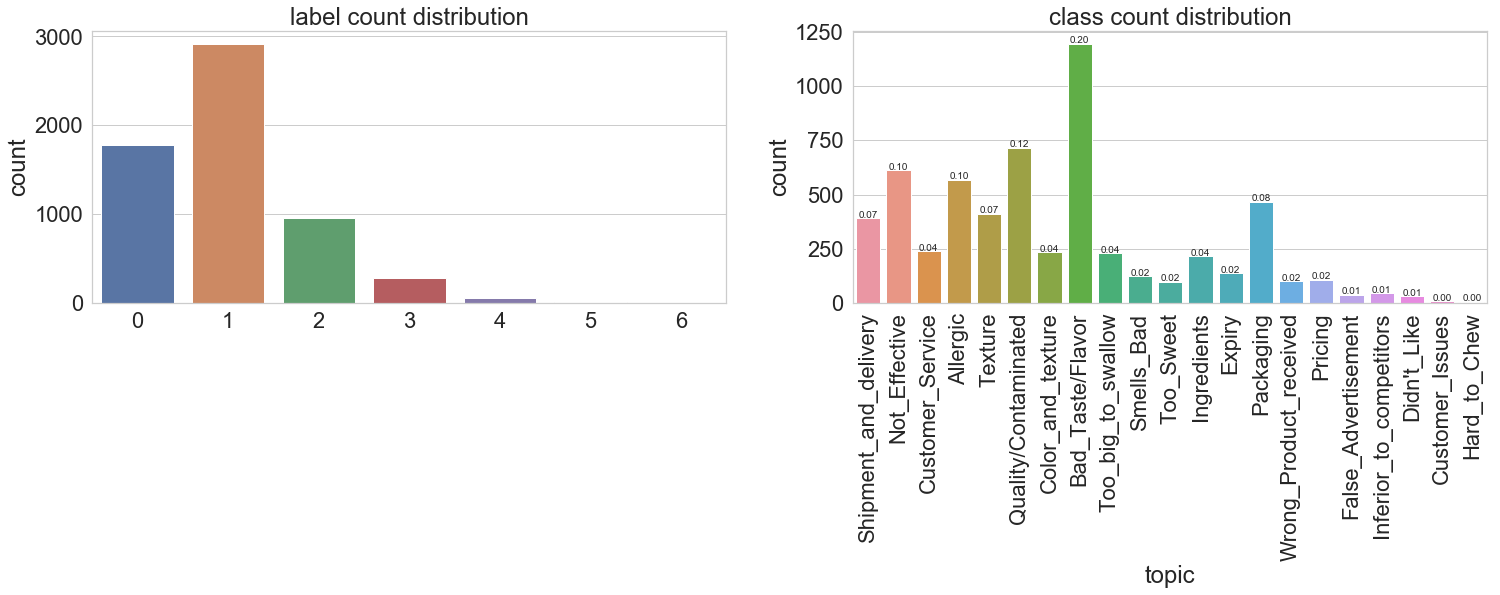

In [53]:
len1 = l_table.sum(axis=1)
fig, ax = plt.subplots(1,2,figsize=(25,5))
print("class count: ", np.bincount(len1))
print("class wise:  ", np.bincount(train['target']))

sns.countplot(len1, ax=ax[0])
ax[0].set_title("label count distribution")
sns.countplot(train['topic'], ax=ax[1])
ax[1].set_title("class count distribution")
for tick in ax[1].get_xticklabels():
    tick.set_rotation(90)
total = train.shape[0]
for p in ax[1].patches:
    height = p.get_height()
    ax[1].text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}'.format(height/total), ha="center") 
    

In [54]:
import gc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF

def tfidf_feature(train, test, col_name, min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=3, stopwords='english', 
                  n_component=120, decom_flag=False, which_method='svd', 
                  max_features=None, feat_col_name='svd'):
    """return tfidf feature
    Args:
        train, test: dataframe
        col_name: column name of text feature
        min_df: if Int, then it represent count of the minimum words in corpus (remove very rare word)
        analyzer: [‘word’, ‘char’]
        ngram: max range of ngram
        token_pattern: [using: r'\w{1,}'] [by default: '(?u)\b\w\w+\b']
        stopwords: ['english' or customized by remove specific words]
        n_component: n_component of svd feature transform
        decom_flag: Wheteher to run svd/nmf on top of that or not (by default: False)
        which_method: which to run [svd or nmf] on top of tfidf (by default: False)
        max_features: max no of features to keep, based on frequency. It will keep words with higher freq
    return:
        Transformed feature space of the text data, as well as tfidf function instance
        if svd_flag== True : train_tf, test_tf, tfv, svd
        else : train_tf, test_tf, tfv
    example:
        train_tfv, test_tfv, tfv = tfidf_feature(X_train, X_test, ['text'], min_df=3)
        train_svd, test_svd, complete_tfv, tfv, svd = tfidf_feature(X_train, X_test, ['text'], 
            min_df=3, svd_component=3, svd_flag=True)

    """
    tfv = TfidfVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, max_df=1.0, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                use_idf=1, smooth_idf=1, sublinear_tf=1,
                stop_words = stopwords)

    complete_df = pd.concat([train[col_name], test[col_name]], axis=0)
#         return complete_df
#         print(complete_df.shape, complete_df.columns)

    tfv.fit(list(complete_df[:].values))

    if decom_flag is False:
        train_tfv =  tfv.transform(train[col_name].values.ravel()) 
        test_tfv  = tfv.transform(test[col_name].values.ravel())

        del complete_df
        gc.collect()
        return train_tfv, test_tfv, tfv
    else:
        complete_tfv = tfv.transform(complete_df[:].values.ravel())
        
        if which_method is 'svd':
            svd = TruncatedSVD(n_components=n_component)
            svd.fit(complete_tfv)
            complete_dec = svd.transform(complete_tfv)
        else:
            nmf = NMF(n_components=n_component, random_state=1234, alpha=0, l1_ratio=0)
            nmf.fit(complete_tfv)            
            complete_dec = nmf.fit_transform(complete_tfv)            
        
        
        complete_dec = pd.DataFrame(data=complete_dec)
        complete_dec.columns = [feat_col_name+'_'+str(i) for i in range(n_component)]

        train_dec = complete_dec.iloc[:train.shape[0]]
        test_dec = complete_dec.iloc[train.shape[0]:].reset_index(drop=True)

        del complete_dec, complete_df
        gc.collect()
        print("="*15, " done ", "="*15)
        return train_dec, test_dec, complete_tfv, tfv

def countvect_feature(train, test, col_name, min_df=3, 
                      analyzer='word', token_pattern=r'\w{1,}', 
                      ngram=3, stopwords='english', max_features=None):
    """return CountVectorizer feature
    Args:
        train, test: dataset
        col_name: columns name of the text feature
        min_df: if Int, then it represent count of the minimum words in corpus (remove very rare word)
        analyzer: [‘word’, ‘char’]
        ngram: max range of ngram
        token_pattern: [using: r'\w{1,}'] [by default: '(?u)\b\w\w+\b']
        stopwords: ['english' or customized by remove specific words]
        max_features: max no of features to keep, based on frequency. It will keep words with higher freq
    return:
        Count feature space of the text data, as well as its function instance
    """
    ctv = CountVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                stop_words = stopwords)

    complete_df = pd.concat([train[col_name], test[col_name]], axis=0)
    ctv.fit(list(complete_df[:].values))

    train_tf =  ctv.transform(train[col_name].values.ravel()) 
    test_tf  = ctv.transform(test[col_name].values.ravel())

    del complete_df
    gc.collect()
    return train_tf, test_tf, ctv


In [248]:
def get_count_vectorizer(df, col_name, min_df=3, analyzer='word', stopwords='english', 
                     token_pattern=r'\w{1,}', ngram=3, max_features=None):
    ctv = CountVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                stop_words = stopwords)

    ctv.fit(list(df[col_name].values))

    df_new =  ctv.transform(df[col_name].values.ravel()) 
    return df_new


def get_tfidf_feature(df, col_name, min_df=3, analyzer='word', stopwords='english',
                  token_pattern=r'\w{1,}', ngram=3, max_features=None):

    tfv = TfidfVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, max_df=1.0, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                use_idf=1, smooth_idf=1, sublinear_tf=1,
                stop_words = stopwords)

    tfv.fit(list(df[col_name].values))
    df_new =  tfv.transform(df[col_name].values.ravel()) 
    
    return df_new

In [249]:
print("="*15, "count-vect","="*15)
print("="*15, "text","="*15)
cvect_text_store = []
for ngram in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
#     if ngram < 11 : continue
    cvect = get_count_vectorizer(df1, 'text', ngram)
    print(cvect.shape)
    cvect_text_store.append(cvect)

print("="*15, "title","="*15)
cvect_title_store = []
for ngram in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
#     if ngram < 11 : continue
    cvect = get_count_vectorizer(df1, 'title', ngram)
    print(cvect.shape)
    cvect_title_store.append(cvect)
    
print("="*30)    
print("="*15, "tfidf","="*15)
print("="*15, "text","="*15)

tfidf_text_store = []
for ngram in [1,2,3,4,5,6,7,8,9,10]:
    tfidf = get_tfidf_feature(df1, 'text', ngram=ngram)
    print(tfidf.shape)
    tfidf_text_store.append(tfidf)
    
print("="*15, "title","="*15)
tfidf_title_store = []
for ngram in [1,2,3,4,5,6,7,8,9,10]:
    tfidf = get_tfidf_feature(df1, 'text', ngram=ngram)
    print(tfidf.shape)
    tfidf_title_store.append(tfidf)

=============== count-vect ===============
=============== text ===============
(5993, 207859)
(5993, 21154)
(5993, 10142)
(5993, 6648)
(5993, 5073)
(5993, 4029)
(5993, 3403)
(5993, 2960)
(5993, 2598)
(5993, 2360)
(5993, 2149)
(5993, 1979)
(5993, 1839)
(5993, 1714)
(5993, 1613)
=============== title ===============
(5993, 15559)
(5993, 2339)
(5993, 1372)
(5993, 959)
(5993, 768)
(5993, 623)
(5993, 540)
(5993, 481)
(5993, 421)
(5993, 373)
(5993, 336)
(5993, 310)
(5993, 289)
(5993, 263)
(5993, 246)
=============== tfidf ===============
=============== text ===============
(5993, 3864)
(5993, 9146)
(5993, 10142)
(5993, 10312)
(5993, 10377)
(5993, 10423)
(5993, 10463)
(5993, 10499)
(5993, 10531)
(5993, 10560)
=============== title ===============
(5993, 3864)
(5993, 9146)
(5993, 10142)
(5993, 10312)
(5993, 10377)
(5993, 10423)
(5993, 10463)
(5993, 10499)
(5993, 10531)
(5993, 10560)


In [252]:
for i, data in enumerate(count_vect_text):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = MultinomialNB().fit(X_train, Y_train)
    print('count-vect {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))


NameError: name 'count_vect_text' is not defined

In [253]:
train.shape, train1.shape, l_table.shape, df1.shape

((5959, 4), (4217, 3), (5993, 22), (5993, 3))

In [258]:
target_topic = target_['topic']
target_.drop('topic', axis=1, inplace=True)

In [261]:
l_table_topic = l_table['topic']
l_table.drop('topic', axis=1, inplace=True)

In [262]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split    

acc_table = []

for i, data in enumerate(cvect_text_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf = MultinomialNB().fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
# acc_table.columns = l_table.columns
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
acc_table

,Allergic,Bad_Taste/Flavor,Color_and_texture,Customer_Issues,Customer_Service,Didn't_Like,Expiry,False_Advertisement,Hard_to_Chew,Inferior_to_competitors,Ingredients,Not_Effective,Packaging,Pricing,Quality/Contaminated,Shipment_and_delivery,Smells_Bad,Texture,Too_Sweet,Too_big_to_swallow,Wrong_Product_received
0,0.902370,0.894787,0.950711,0.997156,0.942180,0.990521,0.977251,0.990521,0.998104,0.988626,0.943128,0.883412,0.937441,0.974408,0.871090,0.934597,0.971564,0.919431,0.976303,0.945024,0.977251
1,0.928910,0.876777,0.960190,0.997156,0.937441,0.991469,0.978199,0.989573,0.997156,0.986730,0.951659,0.893839,0.938389,0.971564,0.867299,0.940284,0.968720,0.927014,0.975355,0.958294,0.982938
2,0.924171,0.888152,0.961137,0.998104,0.937441,0.991469,0.985782,0.990521,0.997156,0.989573,0.958294,0.911848,0.931754,0.972512,0.868246,0.939336,0.970616,0.934597,0.979147,0.957346,0.979147
3,0.902370,0.871090,0.947867,0.997156,0.933649,0.990521,0.989573,0.991469,0.998104,0.989573,0.955450,0.899526,0.928910,0.969668,0.853081,0.916588,0.977251,0.924171,0.972512,0.954502,0.981043
4,0.923223,0.865403,0.946919,0.998104,0.932701,0.991469,0.981991,0.989573,0.997156,0.987678,0.946919,0.900474,0.891943,0.970616,0.851185,0.921327,0.973460,0.930806,0.976303,0.961137,0.978199
5,0.912796,0.882464,0.952607,0.997156,0.922275,0.990521,0.991469,0.990521,0.998104,0.989573,0.948815,0.906161,0.918483,0.972512,0.870142,0.917536,0.974408,0.929858,0.968720,0.967773,0.982938
6,0.903318,0.880569,0.941232,0.998104,0.922275,0.991469,0.981043,0.989573,0.998104,0.988626,0.953555,0.890047,0.912796,0.975355,0.869194,0.918483,0.971564,0.927014,0.970616,0.958294,0.971564
7,0.900474,0.886256,0.927014,0.997156,0.904265,0.992417,0.981991,0.987678,0.997156,0.989573,0.937441,0.892891,0.899526,0.966825,0.867299,0.916588,0.969668,0.924171,0.973460,0.947867,0.972512
8,0.909953,0.860664,0.937441,0.998104,0.897630,0.992417,0.982938,0.991469,0.998104,0.988626,0.954502,0.902370,0.898578,0.973460,0.868246,0.912796,0.973460,0.945024,0.966825,0.960190,0.974408
9,0.908057,0.890047,0.928910,0.998104,0.906161,0.992417,0.985782,0.984834,0.998104,0.987678,0.948815,0.889100,0.897630,0.971564,0.874882,0.920379,0.974408,0.918483,0.966825,0.957346,0.963033


In [263]:
acc_table.apply(lambda x: np.mean(x), axis=1)

0     0.950756
1     0.953284
2     0.955541
3     0.949718
4     0.948409
5     0.951659
6     0.948228
7     0.944392
8     0.947010
9     0.945836
10    0.946739
11    0.947281
12    0.946333
13    0.945972
14    0.946784
dtype: float64

In [264]:
acc_table = []

for i, data in enumerate(cvect_title_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf = MultinomialNB().fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
# acc_table.columns = l_table.columns
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
acc_table

,Allergic,Bad_Taste/Flavor,Color_and_texture,Customer_Issues,Customer_Service,Didn't_Like,Expiry,False_Advertisement,Hard_to_Chew,Inferior_to_competitors,Ingredients,Not_Effective,Packaging,Pricing,Quality/Contaminated,Shipment_and_delivery,Smells_Bad,Texture,Too_Sweet,Too_big_to_swallow,Wrong_Product_received
0,0.874882,0.806635,0.910900,0.986730,0.908057,0.985782,0.962085,0.983886,0.992417,0.975355,0.921327,0.865403,0.896682,0.957346,0.839810,0.903318,0.951659,0.875829,0.958294,0.934597,0.968720
1,0.872038,0.816114,0.943128,0.996209,0.930806,0.990521,0.981043,0.989573,0.997156,0.987678,0.948815,0.885308,0.910900,0.970616,0.848341,0.927014,0.967773,0.904265,0.968720,0.943128,0.980095
2,0.892891,0.809479,0.955450,0.996209,0.941232,0.992417,0.982938,0.992417,0.997156,0.985782,0.941232,0.890047,0.929858,0.975355,0.849289,0.922275,0.968720,0.902370,0.969668,0.947867,0.989573
3,0.899526,0.827488,0.955450,0.998104,0.929858,0.991469,0.985782,0.994313,0.998104,0.989573,0.952607,0.892891,0.931754,0.974408,0.865403,0.939336,0.966825,0.907109,0.976303,0.954502,0.983886
4,0.891943,0.832227,0.947867,0.998104,0.942180,0.990521,0.981991,0.994313,0.998104,0.988626,0.948815,0.890047,0.918483,0.972512,0.866351,0.919431,0.972512,0.907109,0.971564,0.959242,0.986730
5,0.903318,0.840758,0.948815,0.998104,0.927962,0.992417,0.989573,0.991469,0.998104,0.988626,0.957346,0.893839,0.922275,0.978199,0.866351,0.936493,0.974408,0.911848,0.977251,0.956398,0.995261
6,0.900474,0.816114,0.959242,0.998104,0.933649,0.992417,0.980095,0.992417,0.998104,0.987678,0.949763,0.893839,0.928910,0.981043,0.872038,0.945024,0.971564,0.911848,0.975355,0.956398,0.989573
7,0.901422,0.826540,0.954502,0.998104,0.934597,0.992417,0.989573,0.992417,0.998104,0.987678,0.946919,0.908057,0.920379,0.981043,0.850237,0.928910,0.963981,0.916588,0.976303,0.964929,0.993365
8,0.905213,0.825592,0.950711,0.998104,0.926066,0.992417,0.980095,0.995261,0.998104,0.989573,0.959242,0.884360,0.919431,0.977251,0.872986,0.932701,0.975355,0.911848,0.975355,0.955450,0.986730
9,0.889100,0.831280,0.957346,0.998104,0.926066,0.992417,0.983886,0.994313,0.998104,0.989573,0.947867,0.894787,0.924171,0.977251,0.882464,0.933649,0.974408,0.923223,0.981043,0.956398,0.985782


In [265]:
acc_table.apply(lambda x: np.mean(x), axis=1)

0     0.926653
1     0.940916
2     0.944392
3     0.948319
4     0.946603
5     0.949944
6     0.949221
7     0.948860
8     0.948183
9     0.949582
10    0.949176
11    0.947416
12    0.947461
13    0.948905
14    0.950666
dtype: float64

In [266]:
acc_table = []

for i, data in enumerate(tfidf_title_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf = MultinomialNB().fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
# acc_table.columns = l_table.columns
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
acc_table

,Allergic,Bad_Taste/Flavor,Color_and_texture,Customer_Issues,Customer_Service,Didn't_Like,Expiry,False_Advertisement,Hard_to_Chew,Inferior_to_competitors,Ingredients,Not_Effective,Packaging,Pricing,Quality/Contaminated,Shipment_and_delivery,Smells_Bad,Texture,Too_Sweet,Too_big_to_swallow,Wrong_Product_received
0,0.888152,0.858768,0.945024,0.998104,0.943128,0.992417,0.968720,0.991469,0.998104,0.989573,0.948815,0.861611,0.910900,0.974408,0.833175,0.911848,0.971564,0.902370,0.977251,0.947867,0.976303
1,0.878673,0.851185,0.945024,0.998104,0.943128,0.992417,0.967773,0.991469,0.998104,0.989573,0.948815,0.872986,0.902370,0.974408,0.838863,0.915640,0.970616,0.903318,0.977251,0.945972,0.976303
2,0.875829,0.836019,0.944076,0.998104,0.942180,0.992417,0.965877,0.991469,0.998104,0.989573,0.946919,0.869194,0.905213,0.972512,0.836967,0.918483,0.970616,0.902370,0.977251,0.945024,0.976303
3,0.878673,0.847393,0.945024,0.998104,0.943128,0.991469,0.966825,0.990521,0.998104,0.988626,0.947867,0.871090,0.909005,0.974408,0.834123,0.913744,0.969668,0.903318,0.977251,0.945972,0.975355
4,0.873934,0.853081,0.945024,0.998104,0.942180,0.992417,0.965877,0.989573,0.998104,0.989573,0.947867,0.872038,0.903318,0.973460,0.833175,0.914692,0.968720,0.903318,0.975355,0.945024,0.974408
5,0.874882,0.836967,0.944076,0.998104,0.943128,0.991469,0.967773,0.990521,0.996209,0.989573,0.947867,0.872038,0.902370,0.972512,0.837915,0.916588,0.969668,0.903318,0.977251,0.945972,0.975355
6,0.873934,0.843602,0.942180,0.996209,0.942180,0.991469,0.966825,0.989573,0.997156,0.988626,0.948815,0.871090,0.899526,0.973460,0.836019,0.916588,0.969668,0.902370,0.977251,0.944076,0.974408
7,0.875829,0.835071,0.944076,0.997156,0.942180,0.991469,0.966825,0.989573,0.997156,0.989573,0.946919,0.867299,0.906161,0.973460,0.835071,0.916588,0.969668,0.902370,0.977251,0.945024,0.976303
8,0.874882,0.849289,0.945024,0.997156,0.943128,0.992417,0.967773,0.991469,0.995261,0.989573,0.947867,0.869194,0.903318,0.974408,0.837915,0.913744,0.968720,0.901422,0.975355,0.945024,0.975355
9,0.875829,0.841706,0.945024,0.995261,0.942180,0.991469,0.967773,0.990521,0.997156,0.988626,0.948815,0.869194,0.896682,0.973460,0.834123,0.912796,0.969668,0.905213,0.975355,0.945024,0.975355


In [267]:
acc_table.apply(lambda x: np.mean(x), axis=1)

0    0.942361
1    0.942000
2    0.940691
3    0.941413
4    0.940916
5    0.940645
6    0.940239
7    0.940239
8    0.940871
9    0.940059
dtype: float64

In [268]:
acc_table = []

for i, data in enumerate(tfidf_text_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf = MultinomialNB().fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
# acc_table.columns = l_table.columns
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
acc_table

,Allergic,Bad_Taste/Flavor,Color_and_texture,Customer_Issues,Customer_Service,Didn't_Like,Expiry,False_Advertisement,Hard_to_Chew,Inferior_to_competitors,Ingredients,Not_Effective,Packaging,Pricing,Quality/Contaminated,Shipment_and_delivery,Smells_Bad,Texture,Too_Sweet,Too_big_to_swallow,Wrong_Product_received
0,0.888152,0.845498,0.945024,0.998104,0.943128,0.992417,0.967773,0.991469,0.998104,0.989573,0.949763,0.867299,0.910900,0.974408,0.835071,0.913744,0.970616,0.902370,0.977251,0.946919,0.976303
1,0.878673,0.850237,0.945024,0.998104,0.943128,0.992417,0.967773,0.991469,0.998104,0.989573,0.948815,0.869194,0.899526,0.974408,0.835071,0.915640,0.970616,0.903318,0.977251,0.946919,0.976303
2,0.872986,0.840758,0.945024,0.998104,0.943128,0.992417,0.966825,0.991469,0.998104,0.989573,0.948815,0.870142,0.898578,0.974408,0.834123,0.913744,0.970616,0.902370,0.977251,0.945024,0.976303
3,0.873934,0.841706,0.943128,0.998104,0.943128,0.992417,0.965877,0.991469,0.998104,0.989573,0.947867,0.874882,0.897630,0.973460,0.836967,0.913744,0.970616,0.901422,0.976303,0.944076,0.976303
4,0.874882,0.861611,0.944076,0.998104,0.942180,0.991469,0.965877,0.990521,0.998104,0.988626,0.948815,0.870142,0.900474,0.972512,0.834123,0.918483,0.970616,0.903318,0.975355,0.945972,0.974408
5,0.875829,0.847393,0.945024,0.997156,0.942180,0.991469,0.967773,0.991469,0.995261,0.988626,0.948815,0.870142,0.898578,0.974408,0.836019,0.913744,0.970616,0.902370,0.975355,0.945972,0.975355
6,0.879621,0.842654,0.943128,0.996209,0.942180,0.991469,0.966825,0.991469,0.998104,0.989573,0.947867,0.870142,0.905213,0.972512,0.835071,0.918483,0.968720,0.902370,0.976303,0.946919,0.976303
7,0.873934,0.861611,0.944076,0.998104,0.942180,0.991469,0.966825,0.990521,0.998104,0.988626,0.948815,0.869194,0.897630,0.973460,0.835071,0.916588,0.969668,0.905213,0.975355,0.944076,0.974408
8,0.873934,0.847393,0.945024,0.997156,0.942180,0.991469,0.966825,0.990521,0.998104,0.988626,0.947867,0.879621,0.896682,0.973460,0.838863,0.911848,0.970616,0.903318,0.976303,0.946919,0.975355
9,0.877725,0.858768,0.944076,0.998104,0.941232,0.992417,0.965877,0.991469,0.996209,0.989573,0.947867,0.872986,0.896682,0.974408,0.835071,0.912796,0.967773,0.903318,0.975355,0.946919,0.976303


In [269]:
acc_table.apply(lambda x: np.mean(x), axis=1)

0    0.942090
1    0.941503
2    0.940465
3    0.940510
4    0.941413
5    0.940645
6    0.941007
7    0.941187
8    0.941052
9    0.941187
dtype: float64

In [270]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    


acc_table = []
clf = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

for i, data in enumerate(cvect_title_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
# acc_table.columns = l_table.columns
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
acc_table

,Allergic,Bad_Taste/Flavor,Color_and_texture,Customer_Issues,Customer_Service,Didn't_Like,Expiry,False_Advertisement,Hard_to_Chew,Inferior_to_competitors,Ingredients,Not_Effective,Packaging,Pricing,Quality/Contaminated,Shipment_and_delivery,Smells_Bad,Texture,Too_Sweet,Too_big_to_swallow,Wrong_Product_received
0,0.873934,0.828436,0.929858,0.995261,0.911848,0.979147,0.980095,0.994313,0.998104,0.945024,0.930806,0.879621,0.930806,0.963981,0.850237,0.927962,0.964929,0.865403,0.961137,0.951659,0.984834
1,0.840758,0.833175,0.914692,0.966825,0.892891,0.963981,0.979147,0.989573,0.993365,0.909953,0.894787,0.875829,0.923223,0.936493,0.845498,0.926066,0.949763,0.826540,0.955450,0.927014,0.980095
2,0.835071,0.835071,0.874882,0.954502,0.885308,0.957346,0.973460,0.987678,0.996209,0.894787,0.875829,0.857820,0.910900,0.922275,0.844550,0.915640,0.944076,0.806635,0.963033,0.910900,0.977251
3,0.846445,0.818009,0.894787,0.970616,0.887204,0.953555,0.971564,0.981043,0.993365,0.905213,0.867299,0.864455,0.898578,0.914692,0.857820,0.914692,0.934597,0.818957,0.955450,0.908057,0.982938
4,0.810427,0.831280,0.876777,0.982938,0.876777,0.917536,0.972512,0.981043,0.994313,0.906161,0.861611,0.860664,0.912796,0.907109,0.841706,0.917536,0.935545,0.797156,0.954502,0.915640,0.981043
5,0.820853,0.835071,0.876777,0.962085,0.886256,0.920379,0.971564,0.987678,0.990521,0.896682,0.886256,0.869194,0.890995,0.908057,0.839810,0.924171,0.936493,0.788626,0.940284,0.909953,0.983886
6,0.775355,0.828436,0.874882,0.947867,0.882464,0.885308,0.959242,0.975355,0.991469,0.890047,0.836967,0.859716,0.892891,0.896682,0.845498,0.918483,0.941232,0.782938,0.938389,0.894787,0.974408
7,0.801896,0.830332,0.870142,0.924171,0.875829,0.918483,0.972512,0.981991,0.976303,0.901422,0.854028,0.860664,0.895735,0.886256,0.854028,0.914692,0.923223,0.789573,0.942180,0.893839,0.974408
8,0.758294,0.831280,0.872986,0.939336,0.891943,0.905213,0.963033,0.968720,0.965877,0.892891,0.852133,0.865403,0.900474,0.889100,0.832227,0.919431,0.908057,0.785782,0.923223,0.919431,0.979147
9,0.751659,0.844550,0.844550,0.935545,0.871090,0.893839,0.966825,0.974408,0.966825,0.892891,0.844550,0.854028,0.882464,0.868246,0.838863,0.907109,0.920379,0.782938,0.922275,0.899526,0.960190


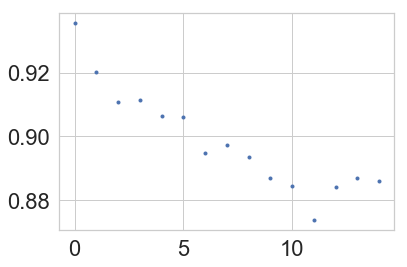

In [271]:
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')

,Allergic,Bad_Taste/Flavor,Color_and_texture,Customer_Issues,Customer_Service,Didn't_Like,Expiry,False_Advertisement,Hard_to_Chew,Inferior_to_competitors,Ingredients,Not_Effective,Packaging,Pricing,Quality/Contaminated,Shipment_and_delivery,Smells_Bad,Texture,Too_Sweet,Too_big_to_swallow,Wrong_Product_received
0,0.921327,0.916588,0.973460,0.998104,0.937441,0.990521,0.993365,0.992417,0.996209,0.986730,0.968720,0.911848,0.945972,0.981991,0.925118,0.945024,0.977251,0.960190,0.978199,0.970616,0.989573
1,0.926066,0.922275,0.976303,0.998104,0.922275,0.982938,0.994313,0.993365,0.998104,0.981991,0.965877,0.910900,0.949763,0.983886,0.918483,0.942180,0.975355,0.966825,0.978199,0.975355,0.968720
2,0.927962,0.922275,0.974408,0.999052,0.915640,0.986730,0.994313,0.995261,0.998104,0.983886,0.966825,0.896682,0.947867,0.980095,0.927014,0.932701,0.970616,0.979147,0.980095,0.978199,0.976303
3,0.927962,0.905213,0.979147,0.999052,0.915640,0.984834,0.993365,0.994313,0.997156,0.975355,0.960190,0.906161,0.944076,0.981043,0.904265,0.926066,0.971564,0.967773,0.979147,0.975355,0.976303
4,0.920379,0.909005,0.981991,1.000000,0.911848,0.987678,0.992417,0.994313,0.996209,0.969668,0.961137,0.891943,0.953555,0.990521,0.921327,0.939336,0.966825,0.971564,0.980095,0.969668,0.978199
5,0.926066,0.906161,0.977251,0.999052,0.910900,0.982938,0.994313,0.996209,0.994313,0.963033,0.972512,0.905213,0.929858,0.981043,0.915640,0.936493,0.969668,0.966825,0.981043,0.976303,0.973460
6,0.929858,0.913744,0.989573,0.998104,0.910900,0.975355,0.995261,0.990521,0.996209,0.966825,0.967773,0.919431,0.939336,0.978199,0.917536,0.927014,0.974408,0.978199,0.980095,0.974408,0.977251
7,0.920379,0.911848,0.968720,0.998104,0.919431,0.976303,0.994313,0.990521,0.998104,0.964929,0.962085,0.903318,0.936493,0.977251,0.913744,0.923223,0.966825,0.972512,0.976303,0.969668,0.974408
8,0.922275,0.924171,0.979147,0.998104,0.918483,0.973460,0.996209,0.994313,0.998104,0.967773,0.962085,0.914692,0.946919,0.980095,0.916588,0.929858,0.969668,0.972512,0.981991,0.968720,0.979147
9,0.922275,0.917536,0.977251,0.999052,0.910900,0.977251,0.994313,0.995261,0.995261,0.965877,0.959242,0.906161,0.943128,0.974408,0.894787,0.940284,0.963981,0.971564,0.975355,0.971564,0.964929


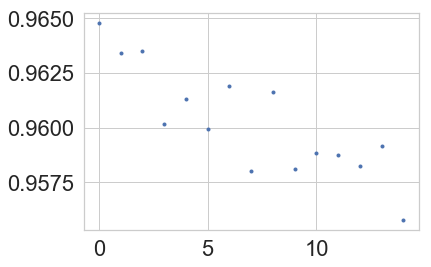

In [272]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    


acc_table = []
clf = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

for i, data in enumerate(cvect_text_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
# acc_table.columns = l_table.columns
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')
acc_table

0     0.964794
1     0.963394
2     0.963485
3     0.960190
4     0.961318
5     0.959919
6     0.961905
7     0.958023
8     0.961634
9     0.958113
10    0.958835
11    0.958745
12    0.958249
13    0.959151
14    0.955766
Name: overall, dtype: float64

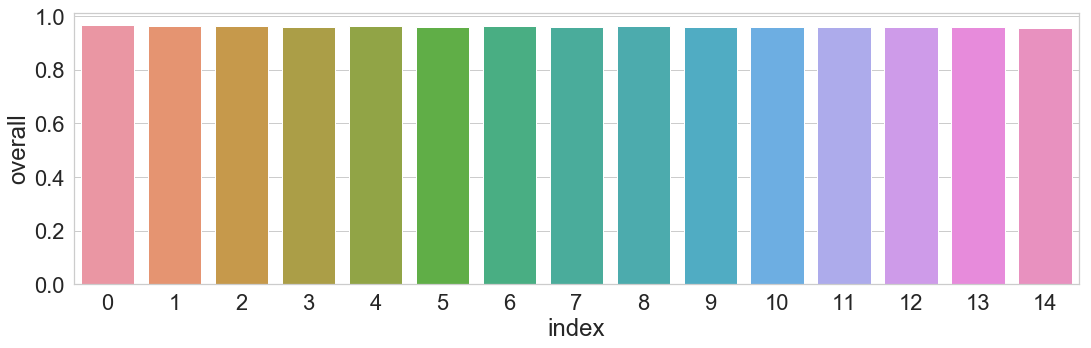

In [273]:
# acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
acc_table['overall'] = acc_table.apply(lambda x: np.mean(x), axis=1)
acc_table = acc_table.reset_index()
fig, ax = plt.subplots(1,1,figsize=(18, 5))
sns.barplot(x='index',y='overall',data=acc_table, ax=ax)
acc_table['overall']

In [274]:
test1['len'] = test1['topic'].apply(lambda x: len(x.split(" ")))

In [275]:
topic_len = test1['len']

,Allergic,Bad_Taste/Flavor,Color_and_texture,Customer_Issues,Customer_Service,Didn't_Like,Expiry,False_Advertisement,Hard_to_Chew,Inferior_to_competitors,Ingredients,Not_Effective,Packaging,Pricing,Quality/Contaminated,Shipment_and_delivery,Smells_Bad,Texture,Too_Sweet,Too_big_to_swallow,Wrong_Product_received
0,0.891943,0.896682,0.900474,0.920379,0.882464,0.910900,0.964929,0.895735,0.940284,0.898578,0.876777,0.876777,0.891943,0.932701,0.883412,0.912796,0.900474,0.919431,0.927014,0.926066,0.935545
1,0.888152,0.896682,0.954502,0.911848,0.907109,0.943128,0.955450,0.921327,0.940284,0.903318,0.905213,0.879621,0.912796,0.934597,0.873934,0.933649,0.940284,0.940284,0.955450,0.931754,0.947867
2,0.909005,0.896682,0.942180,0.970616,0.891943,0.919431,0.977251,0.934597,0.924171,0.909953,0.926066,0.888152,0.922275,0.947867,0.867299,0.942180,0.929858,0.921327,0.925118,0.946919,0.946919
3,0.874882,0.900474,0.951659,0.935545,0.910900,0.858768,0.978199,0.924171,0.832227,0.902370,0.900474,0.886256,0.930806,0.937441,0.876777,0.930806,0.936493,0.950711,0.949763,0.926066,0.957346
4,0.892891,0.902370,0.945972,0.931754,0.895735,0.926066,0.945972,0.922275,0.800948,0.836967,0.910900,0.890995,0.907109,0.910900,0.866351,0.921327,0.937441,0.944076,0.946919,0.946919,0.955450
5,0.913744,0.876777,0.945024,0.956398,0.888152,0.854976,0.949763,0.901422,0.921327,0.933649,0.911848,0.898578,0.926066,0.919431,0.881517,0.950711,0.932701,0.933649,0.949763,0.897630,0.944076
6,0.909953,0.884360,0.940284,0.921327,0.882464,0.950711,0.943128,0.899526,0.909005,0.917536,0.911848,0.890995,0.921327,0.940284,0.872038,0.927014,0.930806,0.910900,0.966825,0.942180,0.969668
7,0.905213,0.893839,0.902370,0.899526,0.862559,0.932701,0.978199,0.882464,0.905213,0.928910,0.915640,0.878673,0.936493,0.964929,0.896682,0.935545,0.922275,0.908057,0.940284,0.892891,0.950711
8,0.892891,0.896682,0.954502,0.892891,0.889100,0.890995,0.968720,0.926066,0.906161,0.946919,0.927014,0.863507,0.924171,0.912796,0.850237,0.931754,0.928910,0.931754,0.960190,0.963981,0.948815
9,0.867299,0.901422,0.954502,0.923223,0.862559,0.910900,0.981991,0.926066,0.942180,0.921327,0.931754,0.875829,0.929858,0.950711,0.865403,0.940284,0.936493,0.935545,0.946919,0.953555,0.922275


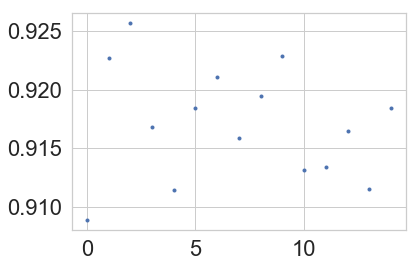

In [299]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore")

acc_table = []
preds = []
clf = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, 
                        max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=4, 
                        random_state=1337, learning_rate='optimal', eta0=0.0, power_t=0.5,
                        early_stopping=True, validation_fraction=0.25, n_iter_no_change=5, 
                        class_weight='balanced', warm_start=False, average=False, n_iter=1000)

for i, data in enumerate(cvect_text_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    test_   = data[train1.shape[0]:]
    
    
    accs = []
    for cls in target_.columns:
        if(cls == 'topic'): continue
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
#         pred = clf.predict_proba(test_)
#         print(cls)
#         preds.append(pred[:,1])
    acc_table.append(accs)
    
    
# acc_table.columns = l_table.columns
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns[:-1])
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')
acc_table

In [276]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    


acc_table = []
preds = []
clf = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

for i, data in enumerate(cvect_text_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    test_   = data[train1.shape[0]:]
    
    
    accs = []
    for cls in target_.columns:
        if(cls == 'topic'): continue
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
        pred = clf.predict_proba(test_)
        print(cls)
        preds.append(pred[:,1])
#     acc_table.append(accs)
    break
    
# # acc_table.columns = l_table.columns
# acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
# plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')
# acc_table

Allergic
Bad_Taste/Flavor
Color_and_texture
Customer_Issues
Customer_Service
Didn't_Like
Expiry
False_Advertisement
Hard_to_Chew
Inferior_to_competitors
Ingredients
Not_Effective
Packaging
Pricing
Quality/Contaminated
Shipment_and_delivery
Smells_Bad
Texture
Too_Sweet
Too_big_to_swallow
Wrong_Product_received


In [277]:
preds1 = np.array(preds).T
# np.argsort(preds1, axis=1)

In [278]:
np.argsort(preds1)

array([[ 8,  3,  9, ..., 14,  0,  1],
       [ 8, 16,  0, ...,  7, 15, 20],
       [ 8, 16,  5, ..., 19, 20,  1],
       ...,
       [ 5,  8, 20, ..., 11, 14,  1],
       [ 3,  5,  7, ..., 14,  1, 12],
       [ 3,  8,  9, ...,  0, 11,  6]])

In [279]:
np.repeat(1,3)

array([1, 1, 1])

In [280]:
preds_final = []
for pred, len_ in zip(preds1, topic_len):
    high = np.argsort(pred)[-1]
#     print([high for i in len_])
    preds_final.append(np.repeat(high, len_))
    

In [281]:
preds_final

[array([1]),
 array([20, 20]),
 array([1, 1, 1]),
 array([15]),
 array([13]),
 array([11]),
 array([12]),
 array([10]),
 array([1, 1]),
 array([10]),
 array([1]),
 array([19]),
 array([10, 10]),
 array([0]),
 array([19]),
 array([1]),
 array([11]),
 array([2, 2]),
 array([18]),
 array([16]),
 array([1, 1]),
 array([15, 15]),
 array([1]),
 array([0]),
 array([14, 14]),
 array([6, 6]),
 array([11, 11, 11]),
 array([0]),
 array([0, 0]),
 array([11]),
 array([18, 18]),
 array([1]),
 array([12]),
 array([0]),
 array([6]),
 array([1]),
 array([1]),
 array([15]),
 array([16]),
 array([4]),
 array([4]),
 array([12]),
 array([1, 1]),
 array([15]),
 array([1, 1]),
 array([17]),
 array([17, 17]),
 array([1, 1, 1]),
 array([14, 14, 14, 14]),
 array([11]),
 array([14, 14]),
 array([17, 17]),
 array([17, 17, 17]),
 array([1]),
 array([14, 14]),
 array([14, 14]),
 array([14, 14]),
 array([14, 14]),
 array([14, 14]),
 array([14, 14]),
 array([14, 14, 14]),
 array([11, 11]),
 array([17]),
 array([15]),

In [282]:
np.array(preds).T.shape

(1776, 21)

In [283]:
preds = np.array(preds)
preds

array([[1.96409578e-01, 2.30484153e-05, 8.48905141e-02, ...,
        8.29280824e-02, 1.99686281e-01, 1.53855245e-01],
       [5.67328076e-01, 6.01306670e-04, 5.35583302e-01, ...,
        9.28365557e-01, 2.51059346e-01, 1.14126888e-01],
       [1.02439521e-01, 3.09886675e-04, 5.83075852e-02, ...,
        1.30731623e-01, 1.05649094e-01, 3.82157622e-02],
       ...,
       [7.24191859e-02, 5.59979491e-05, 1.03122419e-02, ...,
        3.90416734e-02, 9.76567893e-02, 2.81227822e-02],
       [4.93076129e-02, 3.76096633e-04, 3.44701696e-01, ...,
        9.34185307e-02, 1.19781654e-01, 3.95687691e-02],
       [4.16788535e-02, 9.99999997e-01, 5.20386254e-01, ...,
        3.46782513e-02, 1.03607298e-01, 7.28002427e-02]])

In [284]:
l_table.columns

Index(['Allergic', 'Bad_Taste/Flavor', 'Color_and_texture', 'Customer_Issues',
       'Customer_Service', 'Didn't_Like', 'Expiry', 'False_Advertisement',
       'Hard_to_Chew', 'Inferior_to_competitors', 'Ingredients',
       'Not_Effective', 'Packaging', 'Pricing', 'Quality/Contaminated',
       'Shipment_and_delivery', 'Smells_Bad', 'Texture', 'Too_Sweet',
       'Too_big_to_swallow', 'Wrong_Product_received'],
      dtype='object')

In [285]:
# preds.shape, l_table.shape
preds = preds.T
preds = pd.DataFrame(data=l_table, columns=l_table.columns)
preds

,Allergic,Bad_Taste/Flavor,Color_and_texture,Customer_Issues,Customer_Service,Didn't_Like,Expiry,False_Advertisement,Hard_to_Chew,Inferior_to_competitors,Ingredients,Not_Effective,Packaging,Pricing,Quality/Contaminated,Shipment_and_delivery,Smells_Bad,Texture,Too_Sweet,Too_big_to_swallow,Wrong_Product_received
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [286]:
preds['topic'] = preds.apply(lambda x: [i for i,xs in enumerate(x) if xs is 1], axis=1)


In [287]:
preds_final = [list(x) for x in preds_final]
test1['final'] = np.array(preds_final)
test1.head()

,text,title,topic,len,final,final1
0,"""Stir for 30 seconds until product dissolves.""...",Does Not Dissolve,null,1,[1],[Bad_Taste/Flavor]
1,"""X Brand"" has failed to deliver what they offe...","The 3-pack does not come with 3, only 1.",null null,2,"[20, 20]","[Packaging, Packaging]"
2,"""X Brand"" is screwing products. They sent hydr...",Screwed up,null null null,3,"[1, 1, 1]","[Bad_Taste/Flavor, Bad_Taste/Flavor, Bad_Taste..."
3,"""X Brand"" needs to make sure the top is sealed...",Shipping Issues,null,1,[15],[Shipment_and_delivery]
4,*I bought this when I thought I ran out. I re...,Too expensive for the strength.,null,1,[13],[Pricing]


In [288]:
test1['final1'] = test1['final'].apply(lambda x: list(cl_map_inv[xs] for xs in x))

In [289]:
topics_ = test1.final1.apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame('final2')

In [290]:
test2 = test1.reset_index()
topics_ = topics_.reset_index()
test3 = pd.merge(test2, topics_, how="right")
test3.shape

(2553, 8)

In [291]:
test.shape

(2553, 3)

In [300]:
test4 = test3[['text','title','final2']]
test4.columns = sub.columns
test4.head()

,Review Text,Review Title,topic
0,"""Stir for 30 seconds until product dissolves.""...",Does Not Dissolve,Bad_Taste/Flavor
1,"""X Brand"" has failed to deliver what they offe...","The 3-pack does not come with 3, only 1.",Wrong_Product_received
2,"""X Brand"" has failed to deliver what they offe...","The 3-pack does not come with 3, only 1.",Wrong_Product_received
3,"""X Brand"" is screwing products. They sent hydr...",Screwed up,Bad_Taste/Flavor
4,"""X Brand"" is screwing products. They sent hydr...",Screwed up,Bad_Taste/Flavor


In [301]:
test4.to_csv("submission/multilabel_test4.csv",index=None)

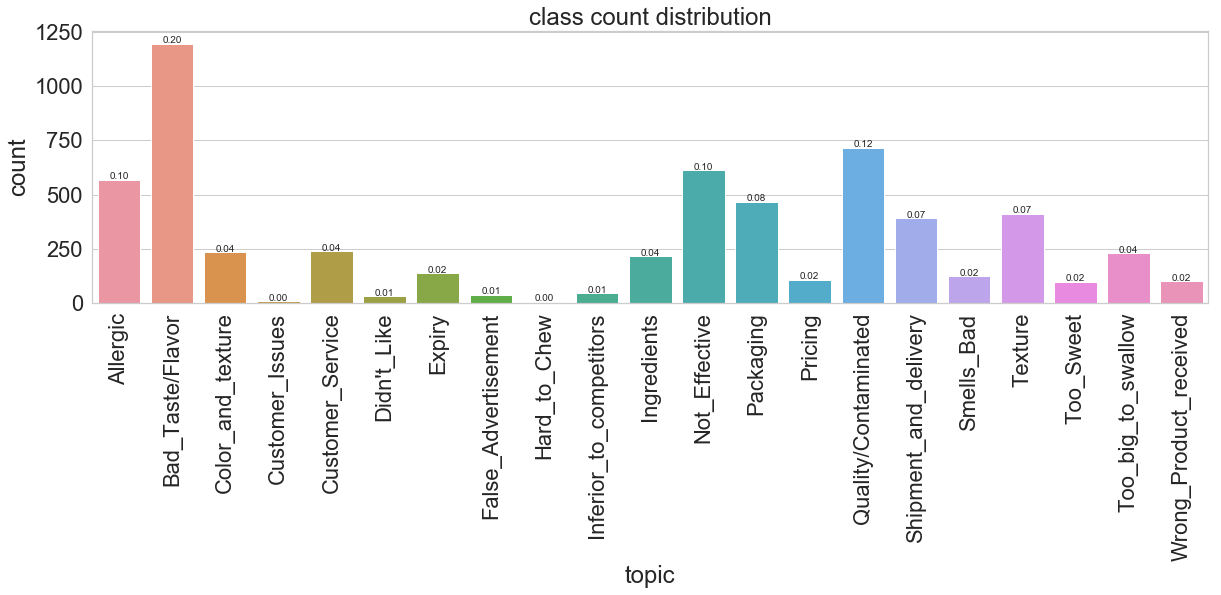

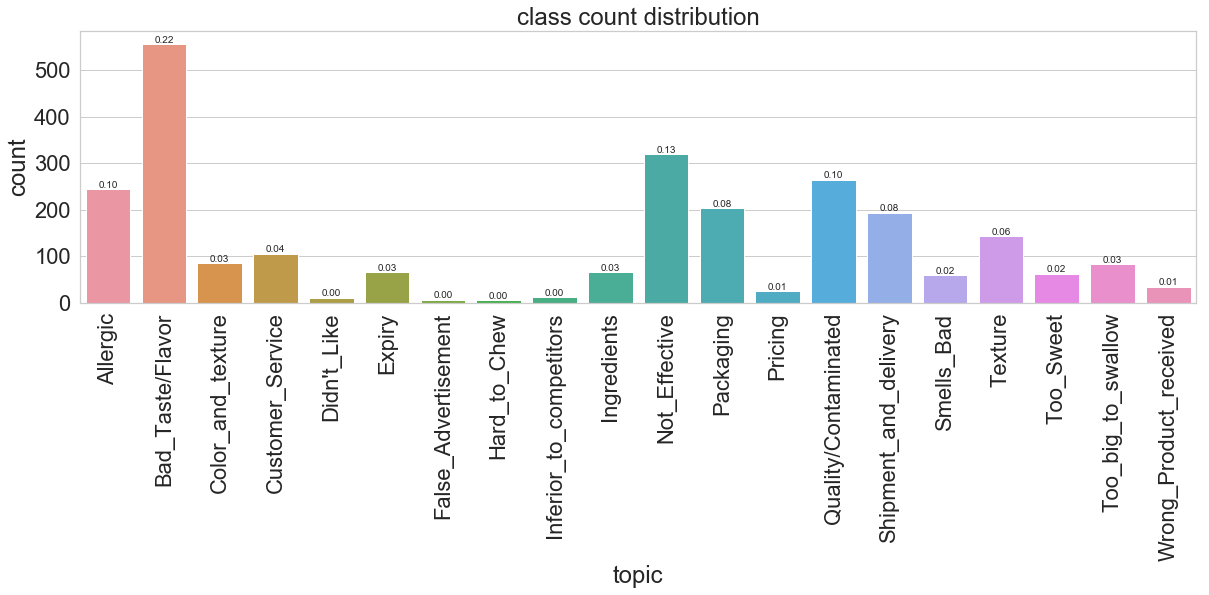

In [224]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.countplot(train['topic'].sort_values(), ax=ax)
ax.set_title("class count distribution")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
total = train.shape[0]
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}'.format(height/total), ha="center") 

fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.countplot(test4['topic'].sort_values(), ax=ax)
ax.set_title("class count distribution")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
total = test4.shape[0]
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}'.format(height/total), ha="center") 
    

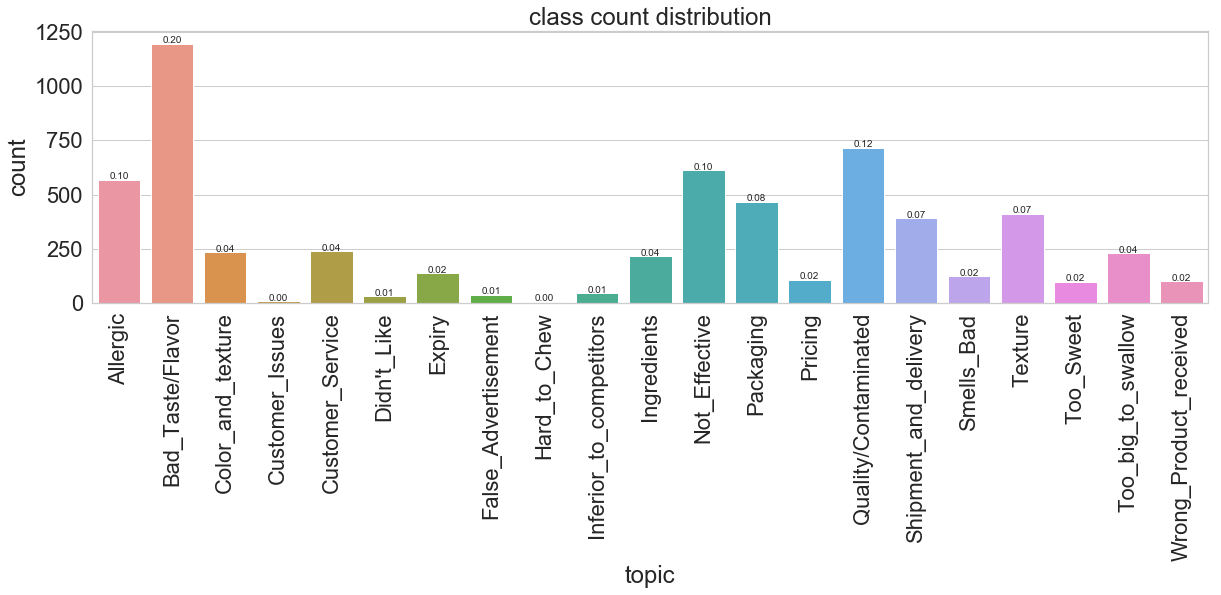

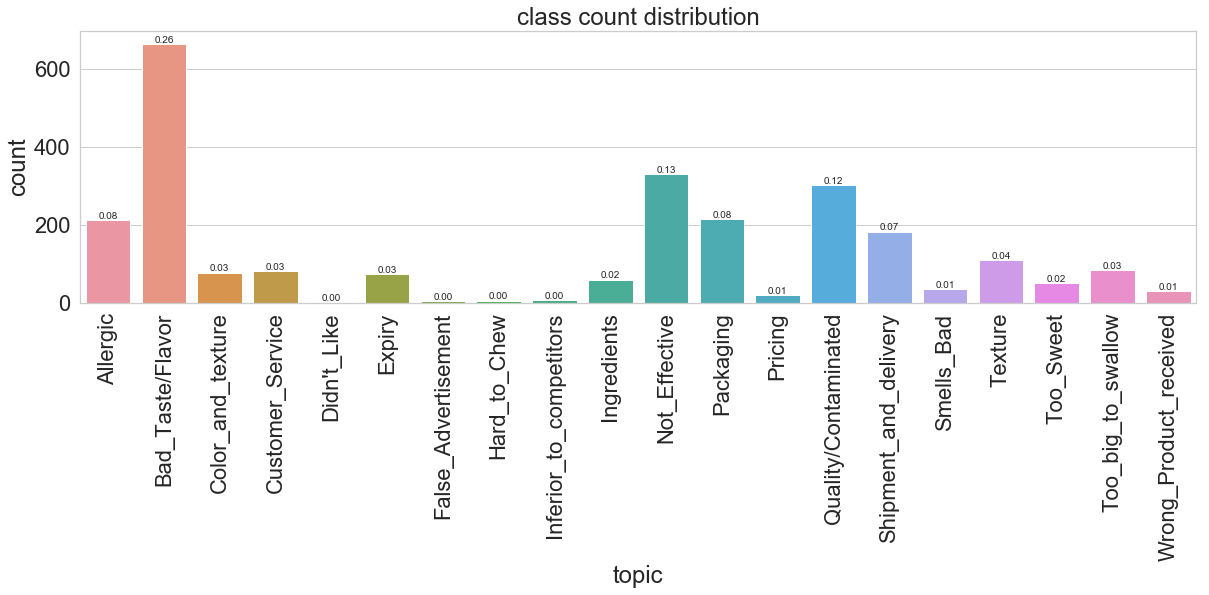

In [244]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.countplot(train['topic'].sort_values(), ax=ax)
ax.set_title("class count distribution")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
total = train.shape[0]
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}'.format(height/total), ha="center") 

fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.countplot(test4['topic'].sort_values(), ax=ax)
ax.set_title("class count distribution")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
total = test4.shape[0]
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}'.format(height/total), ha="center") 
    

In [211]:
sub

,Review Text,Review Title,topic
0,"Not terrible, but not good. Tastes burnt and a...",Not my cup o’ joe,Burnt/ Over -roast
1,"I am so disappointed, it has no flavor, doesn'...","I am so disappointed, it has no flavor",Bad Flavor/Taste
2,"I recently gave up my daily 6 cups of coffee, ...",Flavor was dissapointing,Bitter
3,Meh. I've adored Peruvian coffee for 20 years....,Smooth but majorly bland. Won't repurchase.,NaN
4,Meh. I've adored Peruvian coffee for 20 years....,Smooth but majorly bland. Won't repurchase.,NaN


In [142]:
cl_map

{'Allergic': 0,
 'Bad_Taste/Flavor': 1,
 'Color_and_texture': 2,
 'Customer_Issues': 3,
 'Customer_Service': 4,
 "Didn't_Like": 5,
 'Expiry': 6,
 'False_Advertisement': 7,
 'Hard_to_Chew': 8,
 'Inferior_to_competitors': 9,
 'Ingredients': 10,
 'Not_Effective': 11,
 'Packaging': 12,
 'Pricing': 13,
 'Quality/Contaminated': 14,
 'Shipment_and_delivery': 15,
 'Smells_Bad': 16,
 'Texture': 17,
 'Too_Sweet': 18,
 'Too_big_to_swallow': 19,
 'Wrong_Product_received': 20}

,index,Allergic,Bad_Taste/Flavor,Color_and_texture,Customer_Issues,Customer_Service,Didn't_Like,Expiry,False_Advertisement,Hard_to_Chew,Inferior_to_competitors,Ingredients,Not_Effective,Packaging,Pricing,Quality/Contaminated,Shipment_and_delivery,Smells_Bad,Texture,Too_Sweet,Too_big_to_swallow,Wrong_Product_received,overall
0,0,0.918483,0.894787,0.968720,0.999052,0.901422,0.988626,0.993365,0.994313,0.999052,0.981043,0.963033,0.891943,0.941232,0.979147,0.914692,0.927014,0.960190,0.952607,0.977251,0.981991,0.969668,0.957030
1,1,0.919431,0.904265,0.968720,0.998104,0.916588,0.988626,0.992417,0.994313,0.997156,0.983886,0.960190,0.894787,0.938389,0.985782,0.913744,0.941232,0.963033,0.959242,0.973460,0.976303,0.975355,0.959287
2,2,0.924171,0.903318,0.973460,0.999052,0.921327,0.987678,0.996209,0.992417,0.999052,0.979147,0.965877,0.911848,0.948815,0.984834,0.909005,0.938389,0.964929,0.951659,0.987678,0.976303,0.981991,0.961769
3,3,0.915640,0.890995,0.974408,1.000000,0.929858,0.991469,0.993365,0.992417,0.998104,0.983886,0.969668,0.908057,0.934597,0.981991,0.908057,0.932701,0.974408,0.951659,0.984834,0.971564,0.976303,0.960190
4,4,0.909953,0.896682,0.980095,0.999052,0.909953,0.991469,0.994313,0.991469,0.998104,0.982938,0.970616,0.910900,0.939336,0.985782,0.906161,0.933649,0.970616,0.954502,0.981043,0.982938,0.975355,0.960235
5,5,0.918483,0.907109,0.971564,0.998104,0.931754,0.992417,0.994313,0.992417,0.998104,0.987678,0.967773,0.900474,0.925118,0.983886,0.903318,0.927962,0.968720,0.952607,0.985782,0.968720,0.980095,0.959828
6,6,0.899526,0.894787,0.971564,0.999052,0.914692,0.988626,0.993365,0.993365,0.998104,0.982938,0.960190,0.901422,0.938389,0.984834,0.912796,0.935545,0.969668,0.958294,0.982938,0.981991,0.979147,0.959106
7,7,0.929858,0.907109,0.966825,1.000000,0.923223,0.991469,0.990521,0.995261,0.998104,0.982938,0.971564,0.893839,0.942180,0.981991,0.910900,0.937441,0.971564,0.961137,0.982938,0.975355,0.974408,0.961363
8,8,0.925118,0.900474,0.981043,0.999052,0.909005,0.991469,0.992417,0.993365,0.998104,0.984834,0.965877,0.902370,0.935545,0.981991,0.909005,0.929858,0.968720,0.958294,0.985782,0.976303,0.973460,0.960099
9,9,0.914692,0.895735,0.972512,0.999052,0.920379,0.993365,0.994313,0.994313,0.999052,0.980095,0.967773,0.906161,0.946919,0.980095,0.902370,0.937441,0.971564,0.960190,0.982938,0.976303,0.983886,0.960912


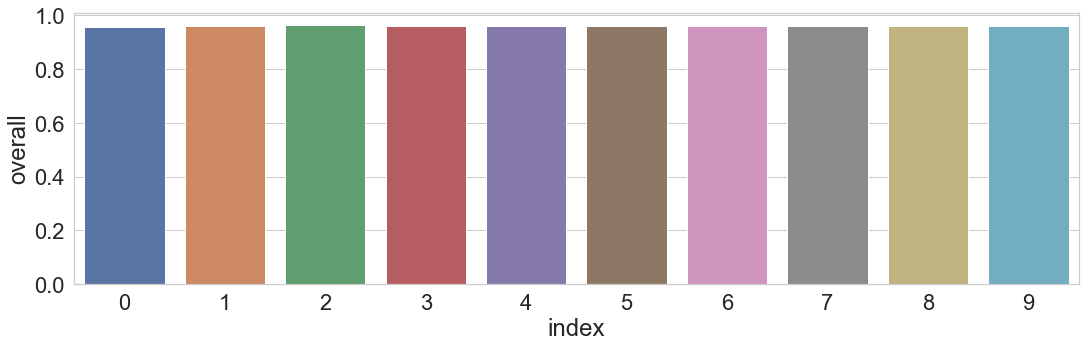

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    


acc_table = []
clf = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

for i, data in enumerate(tfidf_text_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
# acc_table.columns = l_table.columns
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
acc_table['overall'] = acc_table.apply(lambda x: np.mean(x), axis=1)
acc_table = acc_table.reset_index()
fig, ax = plt.subplots(1,1,figsize=(18, 5))
sns.barplot(x='index',y='overall',data=acc_table, ax=ax)
acc_table

,index,Allergic,Bad_Taste/Flavor,Color_and_texture,Customer_Issues,Customer_Service,Didn't_Like,Expiry,False_Advertisement,Hard_to_Chew,Inferior_to_competitors,Ingredients,Not_Effective,Packaging,Pricing,Quality/Contaminated,Shipment_and_delivery,Smells_Bad,Texture,Too_Sweet,Too_big_to_swallow,Wrong_Product_received,overall
0,0,0.905213,0.902370,0.970616,0.998104,0.901422,0.983886,0.997156,0.995261,0.997156,0.978199,0.966825,0.896682,0.934597,0.987678,0.909005,0.927014,0.968720,0.963981,0.978199,0.971564,0.974408,0.957527
1,1,0.921327,0.898578,0.981043,0.999052,0.920379,0.991469,0.993365,0.995261,0.998104,0.981991,0.966825,0.908057,0.946919,0.983886,0.909005,0.943128,0.965877,0.953555,0.981991,0.974408,0.977251,0.961499
2,2,0.919431,0.888152,0.978199,0.999052,0.916588,0.992417,0.995261,0.996209,0.998104,0.983886,0.965877,0.914692,0.947867,0.983886,0.900474,0.937441,0.964929,0.955450,0.981991,0.976303,0.980095,0.960776
3,3,0.918483,0.895735,0.976303,0.999052,0.927962,0.988626,0.993365,0.993365,0.998104,0.986730,0.963981,0.891943,0.936493,0.982938,0.911848,0.934597,0.965877,0.961137,0.981043,0.984834,0.972512,0.960235
4,4,0.925118,0.890047,0.977251,0.998104,0.909005,0.991469,0.992417,0.993365,0.998104,0.987678,0.964929,0.908057,0.934597,0.984834,0.912796,0.935545,0.969668,0.959242,0.976303,0.980095,0.975355,0.960190
5,5,0.923223,0.902370,0.978199,0.999052,0.912796,0.990521,0.989573,0.993365,0.998104,0.983886,0.964929,0.904265,0.937441,0.984834,0.927962,0.931754,0.965877,0.949763,0.976303,0.974408,0.984834,0.960641
6,6,0.910900,0.909005,0.969668,0.999052,0.901422,0.989573,0.993365,0.994313,0.998104,0.984834,0.967773,0.888152,0.943128,0.983886,0.909005,0.945972,0.965877,0.955450,0.980095,0.974408,0.981043,0.959287
7,7,0.910900,0.895735,0.980095,0.999052,0.913744,0.993365,0.994313,0.995261,0.999052,0.980095,0.967773,0.906161,0.949763,0.988626,0.906161,0.935545,0.967773,0.949763,0.977251,0.973460,0.977251,0.960054
8,8,0.917536,0.890995,0.978199,0.999052,0.921327,0.988626,0.994313,0.994313,0.998104,0.981991,0.968720,0.903318,0.931754,0.985782,0.922275,0.932701,0.969668,0.960190,0.982938,0.979147,0.981991,0.961092
9,9,0.911848,0.902370,0.973460,0.999052,0.924171,0.991469,0.995261,0.996209,0.998104,0.985782,0.964929,0.889100,0.952607,0.982938,0.902370,0.928910,0.969668,0.959242,0.981991,0.968720,0.978199,0.959828


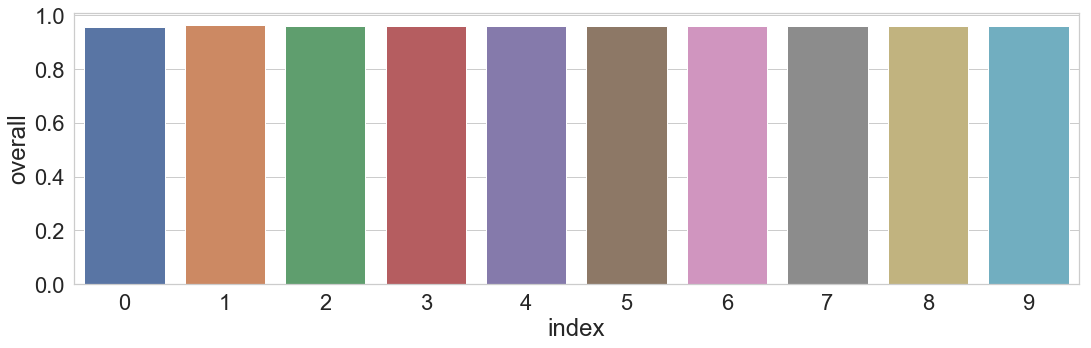

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    


acc_table = []
clf = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

for i, data in enumerate(tfidf_title_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
acc_table['overall'] = acc_table.apply(lambda x: np.mean(x), axis=1)
acc_table = acc_table.reset_index()
fig, ax = plt.subplots(1,1,figsize=(18, 5))
sns.barplot(x='index',y='overall',data=acc_table, ax=ax)

acc_table

## following block can't be run on this dataset, because i manipulated it to multilabel

In [38]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split    

for i, data in enumerate(cvect_text_store):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = MultinomialNB().fit(X_train, Y_train)
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

print("="*30)
for i, data in enumerate(cvect_title_store):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = MultinomialNB().fit(X_train, Y_train)
    print('cvect {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

    
for i, data in enumerate(tfidf_text_store):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = MultinomialNB().fit(X_train, Y_train)
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

print("="*30)
for i, data in enumerate(tfidf_title_store):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = MultinomialNB().fit(X_train, Y_train)
    print('cvect {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))


tfidf 0          acc: 0.3557
tfidf 1          acc: 0.3342
tfidf 2          acc: 0.3315
tfidf 3          acc: 0.3235
tfidf 4          acc: 0.3094
tfidf 5          acc: 0.3067
tfidf 6          acc: 0.3128
tfidf 7          acc: 0.2993
tfidf 8          acc: 0.3181
tfidf 9          acc: 0.3154
count-vect 0          acc: 0.3081
count-vect 1          acc: 0.3295
count-vect 2          acc: 0.3497
count-vect 3          acc: 0.3879
count-vect 4          acc: 0.4013
count-vect 5          acc: 0.4188
count-vect 6          acc: 0.4195
count-vect 7          acc: 0.4383
count-vect 8          acc: 0.4416
count-vect 9          acc: 0.4436


In [41]:
pred = clf.predict(count_vect_text[-1])
pred.shape

(8512,)

In [45]:
pred = pd.DataFrame(data=pred[-test.shape[0]:], columns=['target'])
sub1 = pd.concat([test, pred], axis=1)
sub1['topic'] = sub1['target'].apply(lambda x: cl_map_inv[x])

sub1.drop('target', axis=1, inplace=True)
sub1.columns = sub.columns
sub1.to_csv('submission/sub3_countvect_text_15.csv', index=None)
sub1.head()

,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Bad Taste/Flavor
1,I use chia seed in my protein shakes. These ta...,Bad tast,Bad Taste/Flavor
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients


In [12]:
count_vect = []
for ngram in [1,2,3,4,5,6,8]:
    cvect = get_count_vectorizer(df, 'title', ngram)
    print(cvect.shape)
    count_vect.append(cvect)

(8512, 14131)
(8512, 6430)
(8512, 2958)
(8512, 1650)
(8512, 1155)
(8512, 914)
(8512, 654)


In [13]:
tfidf_store = []
for ngram in [1,2,3,4,5,6,7,8]:
    tfidf = get_tfidf_feature(df, 'title', ngram=ngram)
    print(tfidf.shape)
    tfidf_store.append(tfidf)

(8512, 1183)
(8512, 2369)
(8512, 2958)
(8512, 3240)
(8512, 3382)
(8512, 3452)
(8512, 3484)
(8512, 3496)


In [14]:
tr_len = train.shape[0]
ts_len = test.shape[0]
# train.shape[0] + test.shape[0], df.shape[0]
train1 = df.iloc[:tr_len]
test1  = df.iloc[tr_len:]
train1.shape, test1.shape

((5959, 3), (2553, 3))

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split    

for i, data in enumerate(tfidf_store):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = MultinomialNB().fit(X_train, Y_train)
#     print("tfidf "+str(i), clf.score(X_test, Y_test))
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

    
print("="*30)
for i, data in enumerate(count_vect):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = MultinomialNB().fit(X_train, Y_train)
#     print("count-vect "+str(i), clf.score(X_test, Y_test))
    print('count-vect {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))


tfidf 0 0.39731543624161075
tfidf 1 0.3718120805369127
tfidf 2 0.3818791946308725
tfidf 3 0.3718120805369127
tfidf 4 0.36711409395973155
tfidf 5 0.374496644295302
tfidf 6 0.38456375838926177
tfidf 7 0.3838926174496644
count-vect 0 0.37785234899328857
count-vect 1 0.348993288590604
count-vect 2 0.3812080536912752
count-vect 3 0.4120805369127517
count-vect 4 0.4161073825503356
count-vect 5 0.4120805369127517
count-vect 6 0.4046979865771812


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    
import warnings
warnings.filterwarnings("ignore")

logistic_reg = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

for i, data in enumerate(tfidf_text_store):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = logistic_reg.fit(X_train, Y_train)
#     print("log-reg "+str(i), clf.score(X_test, Y_test))
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

print("="*30)
for i, data in enumerate(count_vect_text):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = logistic_reg.fit(X_train, Y_train)
#     print("log-reg "+str(i), clf.score(X_test, Y_test))
    print('count-vect {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))


tfidf 0          acc: 0.5013
tfidf 1          acc: 0.4946
tfidf 2          acc: 0.4785
tfidf 3          acc: 0.4698
tfidf 4          acc: 0.4698
tfidf 5          acc: 0.4718
tfidf 6          acc: 0.4664
tfidf 7          acc: 0.4564
tfidf 8          acc: 0.4631
tfidf 9          acc: 0.4483
count-vect 0          acc: 0.4477
count-vect 1          acc: 0.4215
count-vect 2          acc: 0.4523
count-vect 3          acc: 0.4651
count-vect 4          acc: 0.4678
count-vect 5          acc: 0.4758
count-vect 6          acc: 0.4705
count-vect 7          acc: 0.4718
count-vect 8          acc: 0.4758
count-vect 9          acc: 0.4752
count-vect 10         acc: 0.4973
count-vect 11         acc: 0.4678
count-vect 12         acc: 0.4725
count-vect 13         acc: 0.4933
count-vect 14         acc: 0.4792


In [60]:
from sklearn.preprocessing import StandardScaler
stdc = StandardScaler()

logistic_reg = LogisticRegression(penalty='l2', dual=False, solver='lbfgs',
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='multinomial', verbose=0, n_jobs=4)

for i, data in enumerate(tfidf_text_store):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
#     X_train = X_train.todense()
#     X_test  = X_test.todense()
#     stdc.fit(X_train)
    clf = logistic_reg.fit(X_train, Y_train)
#     print("log-reg "+str(i), clf.score(X_test, Y_test))
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))


tfidf 0          acc: 0.4557
tfidf 1          acc: 0.4584
tfidf 2          acc: 0.4376
tfidf 3          acc: 0.4362
tfidf 4          acc: 0.4430
tfidf 5          acc: 0.4544
tfidf 6          acc: 0.4396
tfidf 7          acc: 0.4349
tfidf 8          acc: 0.4248
tfidf 9          acc: 0.4450


In [61]:
logistic_reg = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

for i, data in enumerate(tfidf_text_store):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = logistic_reg.fit(X_train, Y_train)
#     print("log-reg "+str(i), clf.score(X_test, Y_test))
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))


tfidf 0          acc: 0.4859
tfidf 1          acc: 0.4893
tfidf 2          acc: 0.4550
tfidf 3          acc: 0.4779
tfidf 4          acc: 0.4624
tfidf 5          acc: 0.4839
tfidf 6          acc: 0.4758
tfidf 7          acc: 0.4812
tfidf 8          acc: 0.4530
tfidf 9          acc: 0.4544


In [78]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, 
                        max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=4, 
                        random_state=1337, learning_rate='optimal', eta0=0.0, power_t=0.5,
                        early_stopping=True, validation_fraction=0.25, n_iter_no_change=5, 
                        class_weight='balanced', warm_start=False, average=False, n_iter=1000)
sgd_clf.fit(X_train, Y_train)
sgd_clf.score(X_test, Y_test)

0.49261744966442955

In [79]:
pred = sgd_clf.predict(X_test)
pred.shape

(1490,)

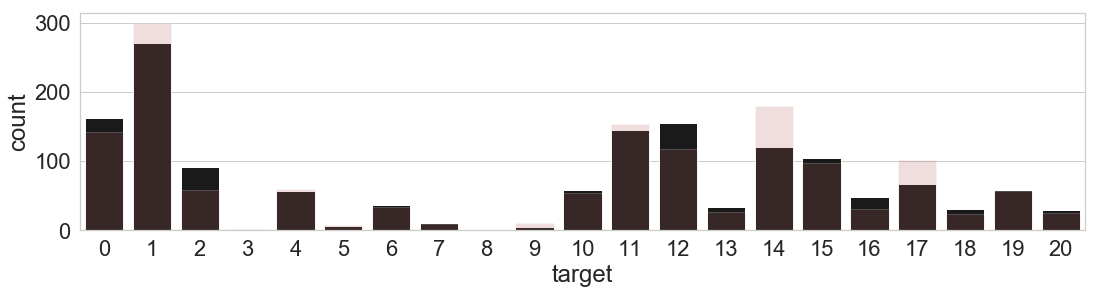

In [95]:
fig, ax = plt.subplots(1,1, figsize=(18, 4))
sns.countplot(pred, color='k', ax=ax)
sns.countplot(Y_test, color='r', ax=ax, alpha=0.2)

In [97]:
for i, data in enumerate(tfidf_text_store):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    
    sgd_clf = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, 
                        max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=4, 
                        random_state=1337, learning_rate='optimal', eta0=0.0, power_t=0.5,
                        early_stopping=True, validation_fraction=0.25, n_iter_no_change=5, 
                        class_weight='balanced', warm_start=False, average=False, n_iter=1000)
    sgd_clf.fit(X_train, Y_train)
#     sgd_clf.score(X_test, Y_test)

#     clf = logistic_reg.fit(X_train, Y_train)
#     print("log-reg "+str(i), clf.score(X_test, Y_test))
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), sgd_clf.score(X_test, Y_test)))


tfidf 0          acc: 0.4866
tfidf 1          acc: 0.4960
tfidf 2          acc: 0.4826
tfidf 3          acc: 0.5148
tfidf 4          acc: 0.5034
tfidf 5          acc: 0.4913
tfidf 6          acc: 0.5020
tfidf 7          acc: 0.4960
tfidf 8          acc: 0.4886
tfidf 9          acc: 0.5087


In [99]:
train_ = tfidf_text_store[4][:train.shape[0]]
test_  = tfidf_text_store[4][train.shape[0]:]

sgd_clf = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, 
                    max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=4, 
                    random_state=1337, learning_rate='optimal', eta0=0.0, power_t=0.5,
                    early_stopping=True, validation_fraction=0.25, n_iter_no_change=5, 
                    class_weight='balanced', warm_start=False, average=False, n_iter=1000)
sgd_clf.fit(train_, train['target'])
pred = sgd_clf.predict(test_)
pred.shape, test.shape

((2553,), (2553, 2))

In [100]:
pred = pd.DataFrame(data=pred[-test.shape[0]:], columns=['target'])
sub1 = pd.concat([test, pred], axis=1)
sub1['topic'] = sub1['target'].apply(lambda x: cl_map_inv[x])

sub1.drop('target', axis=1, inplace=True)
sub1.columns = sub.columns
sub1.to_csv('submission/sub4_tfidf4_sgd.csv', index=None)
sub1.head()

,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Bad Taste/Flavor
1,I use chia seed in my protein shakes. These ta...,Bad tast,Bad Taste/Flavor
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients


In [102]:
sub1.drop_duplicates()

,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Bad Taste/Flavor
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients
5,I used to be loyal customer to this brand. I h...,SMELL HORRIBLE!,Quality/Contaminated
9,I haven’t received it yet.,Shipping,Shipment and delivery
10,"I bought these for my girlfriend, who I couldn...",These suppliments don't work - No suppliment s...,Not Effective
11,"The almonds were sealed, but not dusted separa...","Heated damaged contents...Not dusted almonds, ...",Wrong Product received
12,I really wanted to give these a try and notice...,Vitex,Allergic
14,"I ordered Cherry Vanilla, got BlackBerry. Cus...",Wrong description !!! Or wrong product?,Wrong Product received
16,Buyer beware: these vitamins are not technical...,"These are not vegan, but ""X Brand""'s Customer ...",Ingredients


In [116]:
train.iloc[5941:5945].values

array([["These gummies aren't bad. They really helped me get through a few weeks in my pregnancy where I was gagging on everything, especially my giant usual pre-natal vitamins. The orange and yellow gummies are delicious and basically taste like candy. However, I have to give them 3 stars (and didn't finish my bottle) because the red ones taste very strongly of fish. I had to hold my nose in order to get them down. Eventually I just gave up, used up the orange and yellow, and switched back to my regular pre-natal.",
        'Some flavors have an odd aftertaste...', 'Too Sweet', 18],
       ["These gummies aren't bad. They really helped me get through a few weeks in my pregnancy where I was gagging on everything, especially my giant usual pre-natal vitamins. The orange and yellow gummies are delicious and basically taste like candy. However, I have to give them 3 stars (and didn't finish my bottle) because the red ones taste very strongly of fish. I had to hold my nose in order to get 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    
import warnings
warnings.filterwarnings("ignore")

logistic_reg = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

for i, data in enumerate(tfidf_text_store):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = logistic_reg.fit(X_train, Y_train)
    print("log-reg "+str(i), clf.score(X_test, Y_test))

print("="*30)
for i, data in enumerate(count_vect_text):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = logistic_reg.fit(X_train, Y_train)
    print("log-reg "+str(i), clf.score(X_test, Y_test))


In [188]:
def top_n_accuracy(truths, preds, n):
    best_n = np.argsort(preds, axis=1)[:,-n:]
#     ts = np.argmax(truths, axis=1)
    ts = truths
    success = 0
    for t, p in zip(ts, best_n):
        if t in p:
            success += 1
    return float(success)/preds.shape[0]

In [258]:
import pandas as pd
import numpy as np
import os, gc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from catboost import Pool, CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

# sklearn.metrics.accuracy_score(y_true, y_pred

def train_lgb_model(X_train, y_train, X_valid, y_valid, features, param, num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds model, model_imp
    """
    _train = lgb.Dataset(X_train[features], label=y_train, feature_name=list(features))
    _valid = lgb.Dataset(X_valid[features], label=y_valid,feature_name=list(features))
    
    clf = lgb.train(param, _train, num_round, 
                    valid_sets = [_train, _valid], 
                    verbose_eval=200, 
                    early_stopping_rounds = 25)                  
    
    oof = clf.predict(X_valid[features], num_iteration=clf.best_iteration)
#     test_pred = clf.predict(X_test[features], num_iteration=clf.best_iteration)
    
    lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
    lgb_imp.columns = ['feature','imp']
    
    return oof, clf, lgb_imp
    



def run_cv_lgb(train_df, target, leaves=30):

    param = {
        'bagging_freq'           : 5,
        'bagging_fraction'       : 0.8,
        'boost_from_average'     : 'false',
        'boost'                  : 'gbdt',
        'feature_fraction'       : 0.8,
        'learning_rate'          : 0.01,
        'max_depth'              : -1,
        'metric'                 : 'auc',
#         'min_data_in_leaf'       : 100,
#         'min_sum_hessian_in_leaf': 10.0,
        'num_leaves'             : leaves,
        'num_threads'            : 4,
        'tree_learner'           : 'serial',
#         'objective'              : 'binary',
        'verbosity'              : 1,
    #     'lambda_l1'              : 0.001,
        'lambda_l2'              : 0.1,
        'objective'              : 'multiclassova',
        'is_unbalance'           : True,
        'num_class'              : 21,
    }   
    if leaves is not None:
        param['num_leaves'] = leaves
        print("using leaves: ", param['num_leaves'])

    random_seed = 1234
    n_splits = 4
    num_round = 10000
    feature_imp = pd.DataFrame()
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_lgb = np.zeros((len(train_df), 21))
#     predictions = np.zeros((len(test_df),n_splits))

    clfs = []
    
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        

        num_round = 10000
        oof, clf, lgb_imp = train_lgb_model(X_train, y_train, 
                                            X_valid, y_valid, 
                                            features, param, 
                                            num_round)
        lgb_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, lgb_imp], axis=0)
    
        oof_lgb[valid_index] = oof
#         predictions[:,fold_] = test_pred
        clfs.append(clf)
        
        score = accuracy_score(y_valid, np.argmax(oof, axis=1))
#         print(classification_report(y_valid, np.argmax(oof, axis=1)))
#         score = roc_auc_score(y_valid, oof)
        print( "  auc = ", score )
        print(top_n_accuracy(y_valid, oof, 3))
        print("="*60)
        
#         break
#     return y_valid, oof
        
    feature_imp.imp = feature_imp.imp.astype('float')
    feature_imp = feature_imp.groupby(['feature'])['imp'].mean()
    feature_imp = pd.DataFrame(data=[feature_imp.index, feature_imp.values]).T
    feature_imp.columns=['feature','imp']
    feature_imp = feature_imp.sort_values(by='imp')

    return clfs, feature_imp, oof_lgb



In [255]:
# _, _, _ = run_cv_lgb(train_sparse_matrix, train['target'], leaves=10000)

using leaves:  10000
(4463,) (1496,)
Fold 0
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.405608	valid_1's auc: 0.417911
  auc =  0.16377005347593582
0.3235294117647059
(4465,) (1494,)
Fold 1
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.411251	valid_1's auc: 0.405284
  auc =  0.19143239625167335
0.321954484605087
(4470,) (1489,)
Fold 2
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.401348	valid_1's auc: 0.436842
  auc =  0.1605104096709201
0.2807253190060443
(4479,) (1480,)
Fold 3
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[3]	training's auc: 0.395933	valid_1's auc: 0.392722
  auc =  0.17094594594594595
0.2918918918918919


In [193]:
_, _, _ = run_cv_lgb(train_sparse_matrix, train['target'], leaves=10000)

using leaves:  10000
(4463,) (1496,)
Fold 0
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.408856	valid_1's auc: 0.428366
  auc =  0.30213903743315507
0.5006684491978609
(4465,) (1494,)
Fold 1
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.407776	valid_1's auc: 0.406841
  auc =  0.30522088353413657
0.536144578313253
(4470,) (1489,)
Fold 2
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.413765	valid_1's auc: 0.449881
  auc =  0.29012760241773
0.5023505708529215
(4479,) (1480,)
Fold 3
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.385803	valid_1's auc: 0.392989
  auc =  0.29864864864864865
0.5236486486486487


In [213]:
_, f, _ = run_cv_lgb(train_sparse_matrix, train['target'], leaves=10000)

using leaves:  10000
(4463,) (1496,)
Fold 0
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.406346	valid_1's auc: 0.42111
  auc =  0.3054812834224599
0.517379679144385
(4465,) (1494,)
Fold 1
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.413985	valid_1's auc: 0.415912
  auc =  0.3286479250334672
0.5401606425702812
(4470,) (1489,)
Fold 2
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.419028	valid_1's auc: 0.448459
  auc =  0.2995298858294157
0.5251846877098724
(4479,) (1480,)
Fold 3
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.399299	valid_1's auc: 0.391379
  auc =  0.30743243243243246
0.5324324324324324


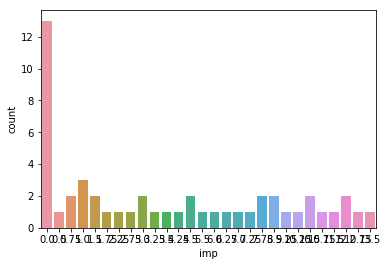

In [231]:
sns.countplot('imp', data=f.sort_values('imp', ascending=False)[:50])

In [207]:
train_ = count_vect[-2][:train.shape[0]]
X_train, X_test, Y_train, Y_test = train_test_split(
    train_, train['target'], 
    stratify=train['target'], 
    test_size=0.25
)
logistic_reg = LogisticRegression(penalty='l2', dual=False, 
    C=0.2, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

clf = logistic_reg.fit(X_train, Y_train)
print("log-reg ", clf.score(X_test, Y_test))

log-reg  0.4006711409395973


In [208]:
from sklearn.feature_selection import SelectFromModel

# model = LogisticRegression(solver='sag')
sfm = SelectFromModel(logistic_reg, threshold=0.25)

In [209]:
train_sparse_matrix = sfm.fit_transform(train_, target)
    

In [210]:
train_sparse_matrix.shape, train_.shape

((5959, 1486), (5959, 1650))

In [211]:
train_sparse_matrix = train_sparse_matrix.todense()
train_sparse_matrix = pd.DataFrame(train_sparse_matrix)
train_sparse_matrix.columns = ['col'+str(i) for i in range(train_sparse_matrix.shape[1])]

In [232]:
train_ = df[:train.shape[0]]
test_  = df[train.shape[0]:]
train_.shape, test_.shape

((5959, 3), (2553, 3))

In [244]:
kuch_title1 = tfidf_feature(train, test, 'title', min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=2, stopwords='english', 
                  n_component=75, decom_flag=True, which_method='svd', 
                  max_features=None, feat_col_name='svd_title1')

kuch_title2 = tfidf_feature(train, test, 'title', min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=3, stopwords='english', 
                  n_component=75, decom_flag=True, which_method='svd', 
                  max_features=None, feat_col_name='svd_title2')

kuch_text11 = tfidf_feature(train, test, 'text', min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=2, stopwords='english', 
                  n_component=100, decom_flag=True, which_method='svd', 
                  max_features=None, feat_col_name='svd_text11')

kuch_text21 = tfidf_feature(train, test, 'text', min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=3, stopwords='english', 
                  n_component=100, decom_flag=True, which_method='svd', 
                  max_features=None, feat_col_name='svd_text21')


kuch_text12 = tfidf_feature(train, test, 'text', min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=2, stopwords='english', 
                  n_component=50, decom_flag=True, which_method='nmf', 
                  max_features=None, feat_col_name='svd_text12')

kuch_text22 = tfidf_feature(train, test, 'text', min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=3, stopwords='english', 
                  n_component=50, decom_flag=True, which_method='nmf', 
                  max_features=None, feat_col_name='svd_text22')


===============  done  ===============
===============  done  ===============
===============  done  ===============
===============  done  ===============
===============  done  ===============
===============  done  ===============


In [245]:
gc.collect()
train_all = pd.concat([kuch_title1[0], kuch_title2[0], kuch_text11[0],
                       kuch_text12[0], kuch_text21[0], kuch_text22[0]], axis=1)
test_all  = pd.concat([kuch_title1[1], kuch_title2[1], kuch_text11[1],
                       kuch_text12[1], kuch_text21[1], kuch_text22[1]], axis=1)

train_all.shape, test_all.shape

((5959, 450), (2553, 450))

In [246]:
_, f, _ = run_cv_lgb(train_all, train['target'], leaves=70)

using leaves:  70
(4463,) (1496,)
Fold 0
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.147056	valid_1's auc: 0.236048
  auc =  0.4391711229946524
0.7179144385026738
(4465,) (1494,)
Fold 1
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.171365	valid_1's auc: 0.218049
  auc =  0.4243641231593039
0.715528781793842
(4470,) (1489,)
Fold 2
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.175862	valid_1's auc: 0.247368
  auc =  0.40899932840832776
0.6991269308260577
(4479,) (1480,)
Fold 3
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.169342	valid_1's auc: 0.221444
  auc =  0.4195945945945946
0.6925675675675675


In [249]:
f.sort_values('imp', ascending=False)[:100]

,feature,imp
300,svd_title1_0,5.5
301,svd_title1_1,3.25
4,svd_text11_12,2.5
133,svd_text12_39,2.5
136,svd_text12_41,2.25
141,svd_text12_46,2.25
121,svd_text12_28,2
132,svd_text12_38,2
345,svd_title1_5,1.75
312,svd_title1_2,1.75


In [251]:
_, f, _ = run_cv_lgb(train_all, train['target'], leaves=200)

using leaves:  50
(4463,) (1496,)
Fold 0
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.147056	valid_1's auc: 0.236048
  auc =  0.4391711229946524
0.7179144385026738
(4465,) (1494,)
Fold 1
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.171365	valid_1's auc: 0.218049
  auc =  0.4243641231593039
0.715528781793842
(4470,) (1489,)
Fold 2
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.175862	valid_1's auc: 0.247368
  auc =  0.40899932840832776
0.6991269308260577
(4479,) (1480,)
Fold 3
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.169342	valid_1's auc: 0.221444
  auc =  0.4195945945945946
0.6925675675675675


In [259]:
_, f, _ = run_cv_lgb(train_all, train['target'], leaves=200)

using leaves:  200
(4463,) (1496,)
Fold 0
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.0635784	valid_1's auc: 0.228486
  auc =  0.33890374331550804
0.6778074866310161
(4465,) (1494,)
Fold 1
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.088599	valid_1's auc: 0.235155
  auc =  0.35876840696117807
0.6927710843373494
(4470,) (1489,)
Fold 2
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.0824321	valid_1's auc: 0.202618
  auc =  0.3364674278038952
0.6830087306917394
(4479,) (1480,)
Fold 3
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.0796541	valid_1's auc: 0.219037
  auc =  0.37027027027027026
0.7047297297297297


In [260]:
f.sort_values('imp', ascending=False)[:100]

,feature,imp
301,svd_title1_1,7.5
89,svd_text11_9,6.75
300,svd_title1_0,6.5
133,svd_text12_39,6.5
4,svd_text11_12,6
12,svd_text11_2,5.75
23,svd_text11_3,5.25
323,svd_title1_3,5
217,svd_text21_7,5
67,svd_text11_7,5


In [265]:

def train_xgb_model(X_train, y_train, X_valid, y_valid, features, param, 
                    num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds, model, model_imp
    """
    _train = xgb.DMatrix(X_train[features], label=y_train, feature_names=list(features))
    _valid = xgb.DMatrix(X_valid[features], label=y_valid,feature_names=list(features))
    
    watchlist = [(_valid, 'valid')]
    clf = xgb.train(dtrain=_train, 
                    num_boost_round=num_round, 
                    evals=watchlist,
                    early_stopping_rounds=25, 
                    verbose_eval=200, 
                    params=param)
    
    valid_frame = xgb.DMatrix(X_valid[features],feature_names=list(features))
    oof  = clf.predict(valid_frame, ntree_limit=clf.best_ntree_limit)


#     test_frame = xgb.DMatrix(X_test[features],feature_names=list(features))
#     test_pred = clf.predict(test_frame, ntree_limit=clf.best_ntree_limit)

    
    xgb_imp = pd.DataFrame(data=[list(clf.get_fscore().keys()), 
                                 list(clf.get_fscore().values())]).T
    xgb_imp.columns = ['feature','imp']
    xgb_imp.imp = xgb_imp.imp.astype('float')
    
#     return oof, test_pred, clf, xgb_imp
    return oof, clf, xgb_imp


# def run_cv_xgb(train_df, target, test_df, depth):
def run_cv_xgb(train_df, target, depth):

    features = train_df.columns
    params = {
        'eval_metric'     : 'auc',
        'seed'            : 1337,
        'eta'             : 0.05,
        'subsample'       : 0.7,
        'colsample_bytree': 0.5,
        'silent'          : 1,
        'nthread'         : 4,
        'Scale_pos_weight': 3.607,
        'objective'       : 'multi:softmax',
        'num_class'       : 21,
        'max_depth'       : depth,
        'alpha'           : 0.05
    }
    
    n_splits = 3
    random_seed = 1234
    feature_imp = pd.DataFrame()
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_xgb = np.zeros((len(train_df), 21))
#     predictions = np.zeros((len(test_df),n_splits))
    clfs = []
##########################
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        

        num_rounds = 10000
        oof, test_pred, clf, xgb_imp = train_xgb_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, params, 
                                                       num_rounds)
        
        xgb_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, xgb_imp], axis=0)
    
        oof_xgb[valid_index] = oof
#         predictions[:,fold_] = test_pred
        clfs.append(clf)
        
        score = accuracy_score(y_valid, np.argmax(oof_xgb, axis=1))
#         print(classification_report(y_valid, np.argmax(oof, axis=1)))
#         score = roc_auc_score(y_valid, oof)
        print( "  auc = ", score )
        print(top_n_accuracy(y_valid, oof_xgb, 3))
        print("="*60)
    
    feature_imp.imp = feature_imp.imp.astype('float')
    feature_imp = feature_imp.groupby(['feature'])['imp'].mean()
    feature_imp = pd.DataFrame(data=[feature_imp.index, feature_imp.values]).T
    feature_imp.columns=['feature','imp']
    feature_imp = feature_imp.sort_values(by='imp')


    return clfs, feature_imp, oof_xgb#, predictions


In [275]:
# run_cv_xgb(train_all, target, depth=4)

In [267]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [270]:
clf = xgb.XGBClassifier(max_depth=4, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(train_all, target)
predictions = clf.predict_proba(train_all)

print ("logloss: %0.3f " % multiclass_logloss(target, predictions))

logloss: 0.522 


In [279]:
X_train, X_test, Y_train, Y_test = train_test_split(
    train_all, train['target'], 
    stratify=train['target'], 
    test_size=0.25
)
X_train.shape, Y_train.shape

((4469, 450), (4469,))

In [273]:
clf = xgb.XGBClassifier(max_depth=4, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(X_train, Y_train)
predictions = clf.predict_proba(X_test)

print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))

score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
print( "  auc = ", score )
print(top_n_accuracy(Y_test, predictions, 3))
print("="*60)
    

logloss: 2.122 
  auc =  0.42348993288590603
0.825503355704698


In [274]:
clf = xgb.XGBClassifier(max_depth=6, n_estimators=50, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(X_train, Y_train)
predictions = clf.predict_proba(X_test)

print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))

score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
print( "  auc = ", score )
print(top_n_accuracy(Y_test, predictions, 3))
print("="*60)
    

logloss: 1.849 
  auc =  0.4268456375838926
0.8315436241610739


In [277]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
scl.fit(train_all)
train_all = scl.transform(train_all)


In [280]:
clf = xgb.XGBClassifier(max_depth=6, n_estimators=50, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(X_train, Y_train)
predictions = clf.predict_proba(X_test)

print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))

score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
print( "  auc = ", score )
print(top_n_accuracy(Y_test, predictions, 3))
print("="*60)
    

logloss: 1.881 
  auc =  0.4161073825503356
0.8422818791946308


In [282]:
# clf = MultinomialNB().fit(X_train, Y_train)
# predictions = clf.predictions
# print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))


logistic_reg = LogisticRegression(penalty='l2', dual=False, 
    C=0.01, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)
logistic_reg.fit(X_train, Y_train)
# predictions = logistic_reg.pred

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=1234,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [284]:
predictions = logistic_reg.predict_proba(X_test)
print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))
score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
print( "  auc = ", score )
print(top_n_accuracy(Y_test, predictions, 3))
print("="*60)


logloss: 1.968 
  auc =  0.5140939597315436
0.8100671140939597


In [285]:
from sklearn.svm import SVC
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(X_train, Y_train)
predictions = clf.predict_proba(X_test)

print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))
score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
print( "  auc = ", score )
print(top_n_accuracy(Y_test, predictions, 3))
print("="*60)


logloss: 1.643 
  auc =  0.4791946308724832
0.812751677852349


In [286]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('../../ml-toolbox-testing/dataset/glove.6B/glove.6B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:27, 14394.11it/s]

Found 400000 word vectors.


In [288]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df[:train.shape[0]]['title'], train['target'], 
    stratify=train['target'], 
    test_size=0.25
)
X_train.shape, Y_train.shape

((4469,), (4469,))

In [298]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()#.decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(X_train)]
xvalid_glove = [sent2vec(x) for x in tqdm(X_test)]








  0%|          | 0/4469 [00:00<?, ?it/s]




 16%|█▋        | 730/4469 [00:00<00:00, 7298.23it/s]




 33%|███▎      | 1463/4469 [00:00<00:00, 7306.10it/s]




 50%|█████     | 2251/4469 [00:00<00:00, 7467.98it/s]




 68%|██████▊   | 3027/4469 [00:00<00:00, 7552.30it/s]




 86%|████████▌ | 3840/4469 [00:00<00:00, 7714.21it/s]




100%|██████████| 4469/4469 [00:00<00:00, 7675.19it/s]




  0%|          | 0/1490 [00:00<?, ?it/s]




 53%|█████▎    | 786/1490 [00:00<00:00, 7856.04it/s]




100%|██████████| 1490/1490 [00:00<00:00, 7561.70it/s]

In [297]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ankish/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [304]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)
xtrain_glove.shape, xvalid_glove.shape

((4469, 300), (1490, 300))

In [305]:
# Fitting a simple xgboost on glove features
# clf = xgb.XGBClassifier(nthread=10, silent=False)
clf = xgb.XGBClassifier(max_depth=6, n_estimators=50, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_glove, Y_train)
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))
score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
print( "  auc = ", score )
print(top_n_accuracy(Y_test, predictions, 3))
print("="*60)


logloss: 2.309 
  auc =  0.33758389261744964
0.6161073825503356


In [348]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_glove, Y_train)
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))
score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
print( "  auc = ", score )
print(top_n_accuracy(Y_test, predictions, 3))
print("="*60)


logloss: 3.201 
  auc =  0.3308724832214765
0.614765100671141


In [349]:
gc.collect()

35126

In [310]:
# scale the data before any neural net:
scl = StandardScaler()
xtrain_glove = scl.fit_transform(xtrain_glove)
xvalid_glove = scl.transform(xvalid_glove)


In [311]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text


Using TensorFlow backend.


In [316]:
try:
    del model
    gc.collect()
else:
    print("no model previously")
# we need to binarize the labels for the neural net
ytrain_enc = np_utils.to_categorical(Y_train)
yvalid_enc = np_utils.to_categorical(Y_test)

# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(21))
model.add(Activation('softmax'))

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 300)               1200      
_________________________________________________________________
dense_8 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 300)               1200      
_________________________________________________________________
dense_9 (Dense)              (None, 21)                6321      
__________

In [320]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(xtrain_glove, y=ytrain_enc, batch_size=64, 
          epochs=3, verbose=1, 
          validation_data=(xvalid_glove, yvalid_enc))


Train on 4469 samples, validate on 1490 samples
Epoch 1/3
4469/4469 [==============================] - 1s 283us/step - loss: 1.2083 - acc: 0.5963 - val_loss: 2.5464 - val_acc: 0.3530
Epoch 2/3
4469/4469 [==============================] - 0s 87us/step - loss: 1.1535 - acc: 0.5979 - val_loss: 2.5796 - val_acc: 0.3477
Epoch 3/3
4469/4469 [==============================] - 0s 88us/step - loss: 1.1485 - acc: 0.6124 - val_loss: 2.5863 - val_acc: 0.3409


In [355]:
batch_size = 128
epochs = 50

In [326]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 17

token.fit_on_texts(list(X_train) + list(X_test))
xtrain_seq = token.texts_to_sequences(X_train)
xvalid_seq = token.texts_to_sequences(X_test)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector








  0%|          | 0/2367 [00:00<?, ?it/s]




100%|██████████| 2367/2367 [00:00<00:00, 301247.65it/s]

In [360]:
try:
    del model
    gc.collect()
except:
    print("no model previously")
    
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(21))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 17, 300)           710400    
_________________________________________________________________
spatial_dropout1d_16 (Spatia (None, 17, 300)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_49 (Dense)             (None, 1024)              103424    
_________________________________________________________________
dropout_33 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_34 (Dropout)         (None, 1024)              0         
__________

In [361]:
from keras.callbacks import EarlyStopping
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=batch_size, epochs=epochs, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])


# model.fit(xtrain_pad, y=ytrain_enc, batch_size=64, 
#           epochs=10, verbose=1, 
#           validation_data=(xvalid_pad, yvalid_enc))


Train on 4469 samples, validate on 1490 samples
Epoch 1/50
4469/4469 [==============================] - 6s 1ms/step - loss: 2.6959 - acc: 0.1821 - val_loss: 2.4985 - val_acc: 0.2322
Epoch 2/50
4469/4469 [==============================] - 3s 671us/step - loss: 2.5046 - acc: 0.2399 - val_loss: 2.3612 - val_acc: 0.3416
Epoch 3/50
4469/4469 [==============================] - 3s 600us/step - loss: 2.3438 - acc: 0.2987 - val_loss: 2.2129 - val_acc: 0.3497
Epoch 4/50
4469/4469 [==============================] - 3s 631us/step - loss: 2.2656 - acc: 0.3269 - val_loss: 2.1535 - val_acc: 0.3658
Epoch 5/50
4469/4469 [==============================] - 3s 711us/step - loss: 2.2204 - acc: 0.3450 - val_loss: 2.1467 - val_acc: 0.3812
Epoch 6/50
4469/4469 [==============================] - 3s 599us/step - loss: 2.1601 - acc: 0.3571 - val_loss: 2.1154 - val_acc: 0.3953
Epoch 7/50
4469/4469 [==============================] - 3s 596us/step - loss: 2.1292 - acc: 0.3808 - val_loss: 2.0727 - val_acc: 0.4020
Ep

In [362]:
try:
    del model
    gc.collect()
except:
    print("no model previously")

# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(21))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 17, 300)           710400    
_________________________________________________________________
spatial_dropout1d_17 (Spatia (None, 17, 300)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_52 (Dense)             (None, 1024)              308224    
_________________________________________________________________
dropout_35 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_36 (Dropout)         (None, 1024)              0         
__________

In [363]:
from keras.callbacks import EarlyStopping
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=batch_size, epochs=epochs, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])


Train on 4469 samples, validate on 1490 samples
Epoch 1/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.6953 - acc: 0.1804 - val_loss: 2.5068 - val_acc: 0.2698
Epoch 2/50
4469/4469 [==============================] - 6s 1ms/step - loss: 2.4504 - acc: 0.2584 - val_loss: 2.3125 - val_acc: 0.3477
Epoch 3/50
4469/4469 [==============================] - 6s 1ms/step - loss: 2.3225 - acc: 0.3142 - val_loss: 2.2211 - val_acc: 0.3611
Epoch 4/50
4469/4469 [==============================] - 6s 1ms/step - loss: 2.2541 - acc: 0.3256 - val_loss: 2.1455 - val_acc: 0.3732
Epoch 5/50
4469/4469 [==============================] - 6s 1ms/step - loss: 2.2084 - acc: 0.3533 - val_loss: 2.1323 - val_acc: 0.3832
Epoch 6/50
4469/4469 [==============================] - 6s 1ms/step - loss: 2.1647 - acc: 0.3654 - val_loss: 2.0669 - val_acc: 0.3946
Epoch 7/50
4469/4469 [==============================] - 10s 2ms/step - loss: 2.1048 - acc: 0.3853 - val_loss: 2.0603 - val_acc: 0.4060
Epoch 8/50
44

In [364]:
try:
    del model
    gc.collect()
except:
    print("no model previously")

# A simple bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(21))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 17, 300)           710400    
_________________________________________________________________
spatial_dropout1d_18 (Spatia (None, 17, 300)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dense_55 (Dense)             (None, 1024)              615424    
_________________________________________________________________
dropout_37 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_38 (Dropout)         (None, 1024)              0         
__________

In [365]:
from keras.callbacks import EarlyStopping
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=batch_size, epochs=epochs, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])


Train on 4469 samples, validate on 1490 samples
Epoch 1/50
4469/4469 [==============================] - 14s 3ms/step - loss: 2.6930 - val_loss: 2.4781
Epoch 2/50
4469/4469 [==============================] - 10s 2ms/step - loss: 2.4610 - val_loss: 2.2849
Epoch 3/50
4469/4469 [==============================] - 10s 2ms/step - loss: 2.3076 - val_loss: 2.1916
Epoch 4/50
4469/4469 [==============================] - 10s 2ms/step - loss: 2.2434 - val_loss: 2.1729
Epoch 5/50
4469/4469 [==============================] - 10s 2ms/step - loss: 2.1994 - val_loss: 2.1053
Epoch 6/50
4469/4469 [==============================] - 10s 2ms/step - loss: 2.1592 - val_loss: 2.0853
Epoch 7/50
4469/4469 [==============================] - 10s 2ms/step - loss: 2.1100 - val_loss: 2.0549
Epoch 8/50
4469/4469 [==============================] - 10s 2ms/step - loss: 2.0700 - val_loss: 2.0334
Epoch 9/50
4469/4469 [==============================] - 10s 2ms/step - loss: 2.0545 - val_loss: 2.0186
Epoch 10/50
4469/4469 [==

In [366]:
try:
    del model
    gc.collect()
except:
    print("no model previously")
    
    
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(21))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 17, 300)           710400    
_________________________________________________________________
spatial_dropout1d_19 (Spatia (None, 17, 300)           0         
_________________________________________________________________
gru_15 (GRU)                 (None, 17, 300)           540900    
_________________________________________________________________
gru_16 (GRU)                 (None, 300)               540900    
_________________________________________________________________
dense_58 (Dense)             (None, 1024)              308224    
_________________________________________________________________
dropout_39 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_59 (Dense)             (None, 1024)              1049600   
__________

In [367]:
from keras.callbacks import EarlyStopping
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=batch_size, epochs=epochs, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])


Train on 4469 samples, validate on 1490 samples
Epoch 1/50
4469/4469 [==============================] - 13s 3ms/step - loss: 2.7085 - acc: 0.1716 - val_loss: 2.5526 - val_acc: 0.2732
Epoch 2/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.5028 - acc: 0.2352 - val_loss: 2.3511 - val_acc: 0.3315
Epoch 3/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.3682 - acc: 0.2998 - val_loss: 2.2801 - val_acc: 0.3423
Epoch 4/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.3073 - acc: 0.3242 - val_loss: 2.2014 - val_acc: 0.3617
Epoch 5/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.2583 - acc: 0.3381 - val_loss: 2.1720 - val_acc: 0.3819
Epoch 6/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.2265 - acc: 0.3394 - val_loss: 2.1587 - val_acc: 0.4067
Epoch 7/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.1944 - acc: 0.3522 - val_loss: 2.1368 - val_acc: 0.4181
Epoch 8/50
44

In [368]:
from keras.engine.topology import Layer
from keras import backend as K
from keras import initializers, regularizers, constraints, optimizers, layers
class Attention(Layer):
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None, bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias: eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True)+K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


In [339]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras import Model

from keras.layers import Bidirectional, CuDNNLSTM, LSTM, CuDNNGRU, GRU, Embedding
from keras.layers import Dense, Input, Dropout, Activation, Conv1D, Flatten, Concatenate
from keras.layers import SpatialDropout1D, Dropout, GlobalMaxPooling1D, MaxPooling1D

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping,ReduceLROnPlateau


In [369]:
try:
    del model
    gc.collect()
except:
    print("no model previously")
    

# GRU with glove embeddings and two dense layers

inp = Input(shape=(max_len,))
x = Embedding(  len(word_index) + 1,
                300,
                weights=[embedding_matrix],
                input_length=max_len,
                trainable=False)(inp)

x = SpatialDropout1D(0.3)(x)
x = GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)(x)
x = GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)(x)

x = Attention(max_len)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.8)(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.8)(x)
x = Dense(21)(x)
x = Activation('softmax')(x)

model = Model(inp, x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 17)                0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 17, 300)           710400    
_________________________________________________________________
spatial_dropout1d_20 (Spatia (None, 17, 300)           0         
_________________________________________________________________
gru_17 (GRU)                 (None, 17, 300)           540900    
_________________________________________________________________
gru_18 (GRU)                 (None, 17, 300)           540900    
_________________________________________________________________
attention_5 (Attention)      (None, 300)               317       
_________________________________________________________________
dense_61 (Dense)             (None, 1024)              308224    
__________

In [370]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))

model.add(Attention(max_len))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(21))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 17, 300)           710400    
_________________________________________________________________
spatial_dropout1d_21 (Spatia (None, 17, 300)           0         
_________________________________________________________________
gru_19 (GRU)                 (None, 17, 300)           540900    
_________________________________________________________________
gru_20 (GRU)                 (None, 17, 300)           540900    
_________________________________________________________________
attention_6 (Attention)      (None, 300)               317       
_________________________________________________________________
dense_64 (Dense)             (None, 1024)              308224    
_________________________________________________________________
dropout_43 (Dropout)         (None, 1024)              0         
__________

In [371]:
from keras.callbacks import EarlyStopping
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=batch_size, epochs=epochs, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])


Train on 4469 samples, validate on 1490 samples
Epoch 1/50
4469/4469 [==============================] - 14s 3ms/step - loss: 2.7430 - acc: 0.1707 - val_loss: 2.5905 - val_acc: 0.2020
Epoch 2/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.5748 - acc: 0.1987 - val_loss: 2.4684 - val_acc: 0.2322
Epoch 3/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.4698 - acc: 0.2493 - val_loss: 2.3137 - val_acc: 0.3188
Epoch 4/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.3434 - acc: 0.3048 - val_loss: 2.2061 - val_acc: 0.3570
Epoch 5/50
4469/4469 [==============================] - 10s 2ms/step - loss: 2.2650 - acc: 0.3327 - val_loss: 2.1630 - val_acc: 0.3711
Epoch 6/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.2222 - acc: 0.3457 - val_loss: 2.1120 - val_acc: 0.3846
Epoch 7/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.1889 - acc: 0.3576 - val_loss: 2.0916 - val_acc: 0.3960
Epoch 8/50
4

In [372]:
try:
    del model
    gc.collect()
except:
    print("no model previously")
    

# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))

model.add(Attention(max_len))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(21))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 17, 300)           710400    
_________________________________________________________________
spatial_dropout1d_22 (Spatia (None, 17, 300)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 17, 600)           1442400   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 17, 600)           2162400   
_________________________________________________________________
attention_7 (Attention)      (None, 600)               617       
_________________________________________________________________
dense_67 (Dense)             (None, 1024)              615424    
_________________________________________________________________
dropout_45 (Dropout)         (None, 1024)              0         
__________

In [373]:
from keras.callbacks import EarlyStopping
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=batch_size, epochs=epochs, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])


Train on 4469 samples, validate on 1490 samples
Epoch 1/50
4469/4469 [==============================] - 34s 8ms/step - loss: 2.7301 - acc: 0.1774 - val_loss: 2.5207 - val_acc: 0.2161
Epoch 2/50
4469/4469 [==============================] - 27s 6ms/step - loss: 2.5041 - acc: 0.2298 - val_loss: 2.3269 - val_acc: 0.2993
Epoch 3/50
4469/4469 [==============================] - 27s 6ms/step - loss: 2.3609 - acc: 0.2873 - val_loss: 2.2491 - val_acc: 0.3403
Epoch 4/50
4469/4469 [==============================] - 26s 6ms/step - loss: 2.2912 - acc: 0.3262 - val_loss: 2.1848 - val_acc: 0.3611
Epoch 5/50
4469/4469 [==============================] - 26s 6ms/step - loss: 2.2233 - acc: 0.3468 - val_loss: 2.1001 - val_acc: 0.3846
Epoch 6/50
4469/4469 [==============================] - 27s 6ms/step - loss: 2.1735 - acc: 0.3580 - val_loss: 2.0771 - val_acc: 0.3913
Epoch 7/50
4469/4469 [==============================] - 29s 6ms/step - loss: 2.1306 - acc: 0.3806 - val_loss: 2.0955 - val_acc: 0.4054
Epoch 8

In [375]:
xvalid_pad.shape

(1490, 17)

In [381]:
xtest_seq = token.texts_to_sequences(df[train.shape[0] : ]['title'])
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)
xtest_pad.shape

(2553, 17)

In [384]:
model.history.history['val_acc']

[0.21610738233031843,
 0.2993288591004058,
 0.3402684564958483,
 0.36107382562336504,
 0.38456375814924304,
 0.39127516790524425,
 0.4053691279968159,
 0.4040268461176213,
 0.4248322142450601,
 0.4248322146050882,
 0.42885906088272197,
 0.42885906088272197,
 0.4295302011822694,
 0.4335570474599032,
 0.43624160993819266,
 0.44026845685587634,
 0.4409395974354456,
 0.4456375843726549,
 0.443624160913813,
 0.45100671088935546,
 0.44832214805103787]

In [385]:
pred = model.predict_classes(xtest_pad, batch_size=500)
pred.shape

(2553,)

In [388]:
np.bincount(target)

array([ 567, 1194,  234,    8,  239,   31,  136,   37,    6,   44,  216,
        611,  467,  107,  715,  390,  123,  410,   97,  228,   99])

In [387]:
np.bincount(pred)

array([207, 862,  43,   0,  92,   0,  67,   0,   0,   0,  56, 279, 238,
        26, 225, 151,  38,  84,  45,  88,  52])

In [393]:
pred = pd.DataFrame(data=pred, columns=['target'])
sub1 = pd.concat([test, pred], axis=1)
sub1['topic'] = sub1['target'].apply(lambda x: cl_map_inv[x])

sub1.drop('target', axis=1, inplace=True)
sub1.to_csv('submission/sub2.csv', index=None)

In [399]:
sub1.columns = sub_df.columns
sub1.head()

,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Quality/Contaminated
1,I use chia seed in my protein shakes. These ta...,Bad tast,Quality/Contaminated
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Bad Taste/Flavor
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Bad Taste/Flavor


In [398]:
sub_df = pd.read_csv('Dataset/Sample_Submission.csv')
sub_df

,Review Text,Review Title,topic
0,"Not terrible, but not good. Tastes burnt and a...",Not my cup o’ joe,Burnt/ Over -roast
1,"I am so disappointed, it has no flavor, doesn'...","I am so disappointed, it has no flavor",Bad Flavor/Taste
2,"I recently gave up my daily 6 cups of coffee, ...",Flavor was dissapointing,Bitter
3,Meh. I've adored Peruvian coffee for 20 years....,Smooth but majorly bland. Won't repurchase.,NaN
4,Meh. I've adored Peruvian coffee for 20 years....,Smooth but majorly bland. Won't repurchase.,NaN


In [400]:
sub1.to_csv('submission/sub2.csv', index=None)

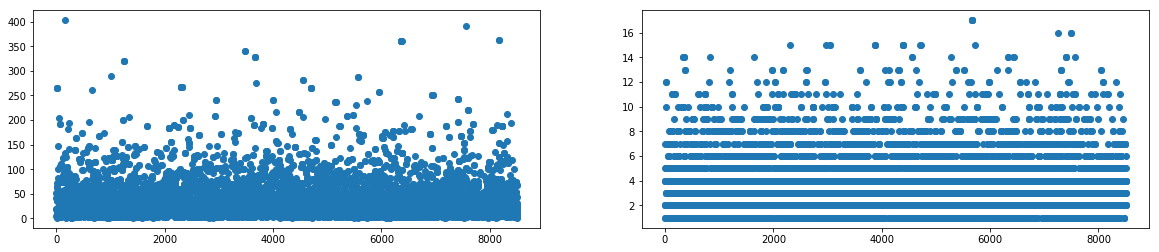

In [14]:
df['wc_text']  = df['text'].apply(lambda x: len(str(x).split(" ")))
df['wc_title'] = df['title'].apply(lambda x: len(str(x).split(" ")))

fig, ax = plt.subplots(1,2,figsize=(20, 4))
ax[0].scatter(range(df.shape[0]), df['wc_text'])
ax[1].scatter(range(df.shape[0]), df['wc_title'])

In [ ]:
# os.makedirs('new_dataset')
# train.to_csv('new_dataset/train1.csv', index=None)
# test.to_csv('new_dataset/test1.csv', index=None)
train.shape, test.shape

In [15]:
def get_quantile(df, col, q1, q2):
    """compute quantile range
    args:
        col: col name
        q1: lower quantile percentile
        q2: upper quantile percentile
    """
    df1 = df[[col]].dropna()
    lower_bound = np.percentile(df1, q=q1)
    upper_bound = np.percentile(df1, q=q2)
    lower_bound = np.round(lower_bound,3)
    upper_bound = np.round(upper_bound, 3)
    min_ = np.round(np.min(df1[col]), 3)
    max_ = np.round(np.max(df1[col]), 3)
    print("Col: {4:<10} min: {0:<10} max: {1:<10} low: {2:<10} high: {3:<10}".format(min_, max_, lower_bound, upper_bound, col))

get_quantile(df, 'wc_text', 1, 95)
get_quantile(df, 'wc_title', 1, 95)

get_quantile(df, 'wc_text', 1, 97)
get_quantile(df, 'wc_title', 1, 97)

get_quantile(df, 'wc_text', 1, 99)
get_quantile(df, 'wc_title', 1, 99)


Col: wc_text    min: 1          max: 403        low: 2.0        high: 119.0     
Col: wc_title   min: 1          max: 17         low: 1.0        high: 8.0       
Col: wc_text    min: 1          max: 403        low: 2.0        high: 144.0     
Col: wc_title   min: 1          max: 17         low: 1.0        high: 10.0      
Col: wc_text    min: 1          max: 403        low: 2.0        high: 196.0     
Col: wc_title   min: 1          max: 17         low: 1.0        high: 12.0      


In [16]:
from keras.engine.topology import Layer
from keras import backend as K
from keras import initializers, regularizers, constraints, optimizers, layers
class Attention(Layer):
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None, bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias: eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True)+K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


Using TensorFlow backend.


In [ ]:
# from keras.models import Model
# from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D
# from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D

# max_features = 50000
# num_classes  = 21
# max_words    = 200
# filter_sizes = [1,2,3,5]
# num_filters  = 36
# inp = Input(shape=(max_words,))
# x = Embedding(max_features, 300, trainable=False)(inp)
# x = Reshape((max_words, 300, 1))(x)
# maxpool_pool = []
# for i in range(len(filter_sizes)):
#     conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], 300),
#                                  kernel_initializer='he_normal', activation='relu')(x)
#     maxpool_pool.append(MaxPool2D(pool_size=(max_words - filter_sizes[i] + 1, 1))(conv))
# z = Concatenate(axis=1)(maxpool_pool)   
# z = Flatten()(z)
# z = Dropout(0.1)(z)
# outp = Dense(num_classes, activation="softmax")(z)
# model = Model(inputs=inp, outputs=outp)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

In [17]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras import Model

from keras.layers import Bidirectional, CuDNNLSTM, LSTM, CuDNNGRU, GRU, Embedding
from keras.layers import Dense, Input, Dropout, Activation, Conv1D, Flatten, Concatenate
from keras.layers import SpatialDropout1D, Dropout, GlobalMaxPooling1D, MaxPooling1D

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping,ReduceLROnPlateau


In [18]:
len(embeddings_index)

400000

In [19]:
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(list(df['text']))
word_index1 = tokenizer1.word_index

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(list(df['title']))
word_index2 = tokenizer2.word_index

len(word_index1), len(word_index2)

(9387, 2830)

In [20]:
max_features1 = len(word_index1) + 1
max_features2 = len(word_index2) + 1

max_words1 = 200
max_words2 = 17

text = tokenizer1.texts_to_sequences(df['text'])
text = pad_sequences(text, maxlen = max_words1)

title = tokenizer2.texts_to_sequences(df['title'])
title = pad_sequences(title, maxlen = max_words2)

text.shape, title.shape

((8512, 200), (8512, 17))

In [21]:
batch_size   = 32
epochs       = 40
num_classes  = 21


In [23]:
inp1 = Input(shape=(max_words1,))
inp2 = Input(shape=(max_words2,))

x1 = Embedding(max_features1, 300, trainable=True)(inp1)
x2 = Embedding(max_features2, 300, trainable=True)(inp2)

x1 = Bidirectional(LSTM(128, return_sequences=True))(x1)
x1 = Bidirectional(LSTM(64, return_sequences=True))(x1)
x1 = Attention(max_words1)(x1)

x2 = Bidirectional(LSTM(64, return_sequences=True))(x2)
x2 = Bidirectional(LSTM(32, return_sequences=True))(x2)
x2 = Attention(max_words2)(x2)

x1, x2

(<tf.Tensor 'attention_3/Sum_1:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'attention_4/Sum_1:0' shape=(?, 64) dtype=float32>)

In [24]:
x = Concatenate(axis=-1)([x1, x2])
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dense(num_classes, activation="softmax")(x)
modelATT = Model(inputs=[inp1, inp2], outputs=x)
modelATT.compile(loss='categorical_crossentropy', 
                 optimizer=Adam(lr=1e-2), metrics=['accuracy'])
modelATT.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 300)     2816400     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 17, 300)      849300      input_4[0][0]                    
__________________________________________________________________________________________________
bidirectio

In [25]:
tr_len = train.shape[0]
ts_len = test.shape[0]
# train.shape[0] + test.shape[0], df.shape[0]
train1 = df.iloc[:tr_len]
test1  = df.iloc[tr_len:]
train1.shape, test.shape

((5959, 5), (2553, 2))

In [26]:
def get_mapping(df, col_name):
    cat_codes = df[col_name].astype('category')
    
    class_mapping = {}
    i = 0
    for col in cat_codes.cat.categories:
        class_mapping[col] = i
        i += 1
    
    class_mapping_reverse = {}
    for key, value in class_mapping.items():
        class_mapping_reverse[value] = key

    return class_mapping, class_mapping_reverse

cl_map, cl_map_inv = get_mapping(train1, 'topic')

In [27]:
train1['target'] = train1['topic'].astype('category').cat.codes
train1['target'] = train1['target'].astype('int')

text_title = np.concatenate([text, title], axis=1)
tr_text_title = text_title[:tr_len]
ts_text_title = text_title[tr_len:]
print(tr_text_title.shape, ts_text_title.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    tr_text_title, train1['target'], shuffle=True,
    stratify=train1['target'], test_size=0.3, random_state=1337
)
X_train.shape, Y_train.shape

(5959, 217) (2553, 217)


((4171, 217), (4171,))

In [28]:
X_tr_text  = X_train[:,:200]
X_tr_title = X_train[:,200:]

X_ts_text  = X_test[:,:200]
X_ts_title = X_test[:,200:]

X_tr_text.shape, X_tr_title.shape, X_ts_text.shape, X_ts_title.shape 

((4171, 200), (4171, 17), (1788, 200), (1788, 17))

In [29]:
from keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes=num_classes)
Y_test  = to_categorical(Y_test, num_classes=num_classes)
Y_train.shape, Y_test.shape

((4171, 21), (1788, 21))

In [30]:
from sklearn.utils import class_weight
def get_class_weights(y):
    """ 
    Example:
        model.fit(X_t, y, batch_size=10, epochs=2,validation_split=0.1,sample_weight=sample_wts)
    
    """
    return class_weight.compute_sample_weight('balanced', y)

cls_wts = get_class_weights(Y_train)
cls_wts

array([1.60750658e-05, 1.85060810e-05, 1.85060810e-05, ...,
       1.95252374e-05, 1.60750658e-05, 5.45514998e-06])

In [31]:
cls_wts.shape

(4171,)

In [34]:
modelATT.compile(loss='categorical_crossentropy', 
                 optimizer=Adam(lr=1e-2), metrics=['accuracy'])

In [35]:
%%time
early_stop = EarlyStopping(monitor="val_acc", patience=1, verbose=1)
history    = modelATT.fit(
    [X_tr_text, X_tr_title], Y_train,
    validation_data = ([X_ts_text, X_ts_title], Y_test),
    epochs          = epochs,
    batch_size      = batch_size,
    verbose         = 1,
    sample_weight   = cls_wts,
    callbacks       = [early_stop]
)

Train on 4171 samples, validate on 1788 samples
Epoch 1/40
4171/4171 [==============================] - 113s 27ms/step - loss: 8.4009e-05 - acc: 0.0173 - val_loss: 3.0743 - val_acc: 0.0358
Epoch 2/40
4171/4171 [==============================] - 103s 25ms/step - loss: 8.3744e-05 - acc: 0.0254 - val_loss: 3.0808 - val_acc: 0.0229
Epoch 00002: early stopping
CPU times: user 11min 22s, sys: 58.9 s, total: 12min 21s
Wall time: 3min 42s


In [ ]:
import gc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF

def tfidf_feature(train, test, col_name, min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=3, stopwords='english', 
                  n_component=120, decom_flag=False, which_method='svd', 
                  max_features=None):
    """return tfidf feature
    Args:
        train, test: dataframe
        col_name: column name of text feature
        min_df: if Int, then it represent count of the minimum words in corpus (remove very rare word)
        analyzer: [‘word’, ‘char’]
        ngram: max range of ngram
        token_pattern: [using: r'\w{1,}'] [by default: '(?u)\b\w\w+\b']
        stopwords: ['english' or customized by remove specific words]
        n_component: n_component of svd feature transform
        decom_flag: Wheteher to run svd/nmf on top of that or not (by default: False)
        which_method: which to run [svd or nmf] on top of tfidf (by default: False)
        max_features: max no of features to keep, based on frequency. It will keep words with higher freq
    return:
        Transformed feature space of the text data, as well as tfidf function instance
        if svd_flag== True : train_tf, test_tf, tfv, svd
        else : train_tf, test_tf, tfv
    example:
        train_tfv, test_tfv, tfv = tfidf_feature(X_train, X_test, ['text'], min_df=3)
        train_svd, test_svd, complete_tfv, tfv, svd = tfidf_feature(X_train, X_test, ['text'], 
            min_df=3, svd_component=3, svd_flag=True)

    """
    tfv = TfidfVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, max_df=1.0, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                use_idf=1, smooth_idf=1, sublinear_tf=1,
                stop_words = stopwords)

    complete_df = pd.concat([train[col_name], test[col_name]], axis=0)
#         return complete_df
#         print(complete_df.shape, complete_df.columns)

    tfv.fit(list(complete_df[:].values))

    if decom_flag is False:
        train_tfv =  tfv.transform(train[col_name].values.ravel()) 
        test_tfv  = tfv.transform(test[col_name].values.ravel())

        del complete_df
        gc.collect()
        return train_tfv, test_tfv, tfv
    else:
        complete_tfv = tfv.transform(complete_df[:].values.ravel())
        
        if which_method is 'svd':
            svd = TruncatedSVD(n_components=n_component)
            svd.fit(complete_tfv)
            complete_dec = svd.transform(complete_tfv)
        else:
            nmf = NMF(n_components=n_component, random_state=1234, alpha=0, l1_ratio=0)
            nmf.fit(complete_tfv)            
            complete_dec = nmf.fit_transform(complete_tfv)            
        
        
        complete_dec = pd.DataFrame(data=complete_dec)
        complete_dec.columns = [which_method+'_'+str(i) for i in range(n_component)]

        train_dec = complete_dec.iloc[:train.shape[0]]
        test_dec = complete_dec.iloc[train.shape[0]:].reset_index(drop=True)

        del complete_dec, complete_df
        gc.collect()
        return train_dec, test_dec, complete_tfv, tfv

def countvect_feature(train, test, col_name, min_df=3, analyzer='word', token_pattern=r'\w{1,}', ngram=3, stopwords='english', max_features=None):
    """return CountVectorizer feature
    Args:
        train, test: dataset
        col_name: columns name of the text feature
        min_df: if Int, then it represent count of the minimum words in corpus (remove very rare word)
        analyzer: [‘word’, ‘char’]
        ngram: max range of ngram
        token_pattern: [using: r'\w{1,}'] [by default: '(?u)\b\w\w+\b']
        stopwords: ['english' or customized by remove specific words]
        max_features: max no of features to keep, based on frequency. It will keep words with higher freq
    return:
        Count feature space of the text data, as well as its function instance
    """
    ctv = CountVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                stop_words = stopwords)

    complete_df = pd.concat([train[col_name], test[col_name]], axis=0)
    ctv.fit(list(complete_df[:].values))

    train_tf =  ctv.transform(train[col_name].values.ravel()) 
    test_tf  = ctv.transform(test[col_name].values.ravel())

    del complete_df
    gc.collect()
    return train_tf, test_tf, ctv


In [ ]:
out_tfidfs = []
for ngram in [1,2,3,4,5]:
    out_tfidfs.append(tfidf_feature(train, test, ''))

In [ ]:
out_tfidf1 = tfidf_feature(train, test, 'text', ngram=1)
out_tfidf2 = tfidf_feature(train, test, 'text', ngram=2)
out_tfidf3 = tfidf_feature(train, test, 'text', ngram=3)
out_tfidf4 = tfidf_feature(train, test, 'text', ngram=5)

out_vect1 = countvect_feature(train, test, 'text', ngram=1)
out_vect2 = countvect_feature(train, test, 'text', ngram=2)
out_vect3 = countvect_feature(train, test, 'text', ngram=3)
out_vect4 = countvect_feature(train, test, 'text', ngram=5)

print('tf-idf features: ', out_tfidf1[0].shape, 
     out_tfidf2[0].shape, out_tfidf3[0].shape, out_tfidf4[0].shape)
print('count-vect features: ', out_vect1[0].shape, 
     out_vect2[0].shape, out_vect3[0].shape, out_vect4[0].shape)


## Multinomial bayes classifier

In [ ]:
train['target'] = train['topic'].astype('category').cat.codes
train['target'] = train['target'].astype('int')
all_class = list(train['target'].unique())
print(len(all_class))

In [ ]:
train[train['target'] == 1].shape, out_tfidf1.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf1[0], train['target'], stratify=train['target'], test_size=0.3
)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, Y_train)
# pred = clf.predict(X_test)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf1[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("tfidf1 : ", clf.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf2[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("tfidf2 : ", clf.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf3[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("tfidf3 : ", clf.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf4[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("tfidf4 : ", clf.score(X_test, Y_test))

print("=="*25)

from sklearn.naive_bayes import MultinomialNB
X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect1[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("count-vect1 : ", clf.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect2[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("count-vect2 : ", clf.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect3[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("count-vect3 : ", clf.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect4[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("count-vect4 : ", clf.score(X_test, Y_test))


In [ ]:
logistic_reg = LogisticRegression(penalty='l2', dual=False, 
    C=0.01, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)
logistic_reg.fit(X_train, Y_train)
print(logistic_reg.score(X_test, Y_test))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import MultinomialNB
X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf1[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("tfidf1 : ", logistic_reg.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf2[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("tfidf2 : ", logistic_reg.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf3[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("tfidf3 : ", logistic_reg.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf4[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("tfidf4 : ", logistic_reg.score(X_test, Y_test))

print("=="*25)

from sklearn.naive_bayes import MultinomialNB
X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect1[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("count-vect1 : ", logistic_reg.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect2[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("count-vect2 : ", logistic_reg.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect3[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("count-vect3 : ", logistic_reg.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect4[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("count-vect4 : ", logistic_reg.score(X_test, Y_test))


In [ ]:
sub_df = pd.read_csv('Dataset/Sample_Submission.csv')
sub_df

In [ ]:
logistic_reg.fit(out_vect3[0], train['target'])
pred = logistic_reg.predict(out_vect3[1])
pred.shape

In [ ]:
# def category_encoder(df)
test.drop('topic', axis=1, inplace=True)
test['target'] = pred
test.head()

In [ ]:
test['topic'] = test['target'].apply(lambda x: class_mapping_reverse[str(x)])

In [ ]:
test.drop('target', axis=1, inplace=True)
# os.makedirs('submission')
test.to_csv('submission/linear_model1.csv', index=None)

In [ ]:
def get_mapping(df, col_name):
    cat_codes = df[col_name].astype('category')
    
    class_mapping = {}
    i = 0
    for col in cat_codes.cat.categories:
        class_mapping[col] = i
        i += 1
    
    class_mapping_reverse = {}
    for key, value in class_mapping.items():
        class_mapping_reverse[value] = key

    return class_mapping, class_mapping_reverse

In [ ]:
class_mapping, class_mapping_reverse = get_mapping(train, 'topic')

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier

params = {}
params['alpha'] = 1
passive_agg = PassiveAggressiveClassifier(C=params['alpha'], early_stopping=False, validation_fraction=0.3, n_iter_no_change=5, shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='hinge', class_weight='balanced', average=False, n_iter=None)
ridge_clf = RidgeClassifier(alpha=params['alpha'], fit_intercept=True, normalize=True, class_weight='balanced', random_state=1234)
logistic_reg = LogisticRegression(penalty='l2', dual=False, C=params['alpha'], fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

In [ ]:
ridge_clf.fit(X_train, Y_train)
print(ridge_clf.score(X_test, Y_test))
print("==============")

passive_agg.fit(X_train, Y_train)
print(passive_agg.score(X_test, Y_test))
print("==============")

logistic_reg.fit(X_train, Y_train)
print(logistic_reg.score(X_test, Y_test))
print("==============")


In [ ]:
from sklearn.metrics import f1_score

for alpha in [0.01, 0.1, 0.5, 1, 5, 10]:
    logistic_reg = LogisticRegression(penalty='l2', dual=False, 
        C=alpha, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
        random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)
    logistic_reg.fit(X_train, Y_train)
    pred = logistic_reg.score(X_test, Y_test)
    print(pred)
#     print(f1_score(ts_y, pred, average='micro', sample_weight=None))
#     print(logistic_reg.score(ts_x, ts_y))
print("==============")

In [ ]:
for alpha in np.linspace(0.0001,0.1,10):
    logistic_reg = LogisticRegression(penalty='l2', dual=False, 
        C=alpha, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
        random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)
    logistic_reg.fit(X_train, Y_train)
    pred = logistic_reg.score(X_test, Y_test)
    print(alpha, " : ", pred)

In [ ]:
Usage: plot_document_classification_20newsgroups.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
data loaded
2034 documents - 3.980MB (training set)
1353 documents - 2.867MB (test set)
4 categories

Extracting features from the training data using a sparse vectorizer
done in 0.412178s at 9.655MB/s
n_samples: 2034, n_features: 33809

Extracting features from the test data using the same vectorizer
done in 0.351330s at 8.162MB/s
n_samples: 1353, n_features: 33809

================================================================================
Ridge Classifier
________________________________________________________________________________
Training:
RidgeClassifier(solver='sag', tol=0.01)
train time: 0.132s
test time:  0.001s
accuracy:   0.896
dimensionality: 33809
density: 1.000000


================================================================================
Perceptron
________________________________________________________________________________
Training:
Perceptron(max_iter=50)
train time: 0.017s
test time:  0.002s
accuracy:   0.888
dimensionality: 33809
density: 0.255302


================================================================================
Passive-Aggressive
________________________________________________________________________________
Training:
PassiveAggressiveClassifier(max_iter=50)
train time: 0.031s
test time:  0.002s
accuracy:   0.904
dimensionality: 33809
density: 0.694674


================================================================================
kNN
________________________________________________________________________________
Training:
KNeighborsClassifier(n_neighbors=10)
train time: 0.002s
test time:  0.317s
accuracy:   0.858

================================================================================
Random forest
________________________________________________________________________________
Training:
RandomForestClassifier(n_estimators=100)
train time: 1.671s
test time:  0.071s
accuracy:   0.840

================================================================================
L2 penalty
________________________________________________________________________________
Training:
LinearSVC(dual=False, tol=0.001)
train time: 0.145s
test time:  0.002s
accuracy:   0.900
dimensionality: 33809
density: 1.000000


________________________________________________________________________________
Training:
SGDClassifier(max_iter=50)
train time: 0.030s
test time:  0.002s
accuracy:   0.902
dimensionality: 33809
density: 0.579380


================================================================================
L1 penalty
________________________________________________________________________________
Training:
LinearSVC(dual=False, penalty='l1', tol=0.001)
train time: 0.301s
test time:  0.002s
accuracy:   0.873
dimensionality: 33809
density: 0.005553


________________________________________________________________________________
Training:
SGDClassifier(max_iter=50, penalty='l1')
train time: 0.093s
test time:  0.002s
accuracy:   0.887
dimensionality: 33809
density: 0.022901


================================================================================
Elastic-Net penalty
________________________________________________________________________________
Training:
SGDClassifier(max_iter=50, penalty='elasticnet')
train time: 0.252s
test time:  0.002s
accuracy:   0.899
dimensionality: 33809
density: 0.187472


================================================================================
NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training:
NearestCentroid()
train time: 0.004s
test time:  0.002s
accuracy:   0.855

================================================================================
Naive Bayes
________________________________________________________________________________
Training:
MultinomialNB(alpha=0.01)
train time: 0.003s
test time:  0.001s
accuracy:   0.899
dimensionality: 33809
density: 1.000000


________________________________________________________________________________
Training:
BernoulliNB(alpha=0.01)
train time: 0.004s
test time:  0.003s
accuracy:   0.884
dimensionality: 33809
density: 1.000000


________________________________________________________________________________
Training:
ComplementNB(alpha=0.1)
train time: 0.004s
test time:  0.001s
accuracy:   0.911
dimensionality: 33809
density: 1.000000


================================================================================
LinearSVC with L1-based feature selection
________________________________________________________________________________
Training:
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1',
                                                     tol=0.001))),
                ('classification', LinearSVC())])
train time: 0.252s
test time:  0.002s
accuracy:   0.880

In [ ]:
# tf_train[i] # feature count vector for training case i
# y_train[i] # label for training case i

# The count vectors are defined as:

# p = sum of all feature count vectors with label 1

# p = tf_train[y_train==1].sum(0) + 1

# q = sum of all feature count vectors with label 0

# q = tf_train[y_train==0].sum(0) + 1

# Notice that we add 1 to both count vectors to ensure that every token appear at least one time in each class.

# The log-count ratio r is:

# r = np.log((p/p.sum()) / (q/q.sum()))

# And b:

# b = np.log(len(p) / len(q))

# Just the ratio of number of positive and negative training cases.

In [ ]:
pre_preds = tf_test @ r.T + b
preds = pre_preds.T > 0
accuracy = (preds == y_test).mean()

In [ ]:
out_tfidf1[0][train['target'] == 5].sum(0)

In [ ]:
out_tfidf1[0][train['target'] == 4].sum(0)

In [ ]:
np.sum(np.equal(out_tfidf1[0][train['target'] == 5].sum(0), 
                out_tfidf1[0][train['target'] == 3].sum(0)))

In [ ]:
out_tfidf1[0][train['target'] == 5].shape

In [ ]:
out_tfidf1[0][train['target'] == 2].shape

In [ ]:
idx = train[train['target'] == 2].index

In [ ]:
out_tfidf1[0][idx].sum(0)

In [ ]:
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

# train['text1'] = train['text'].progress_apply(lemmatization)
# test['text1']  = test['text'].progress_apply(lemmatization)


In [ ]:
df = train.append(test, ignore_index=True)
df['text1'] = df['text'].apply(lemmatization)

In [ ]:
df[:5]['text'].apply(lemmatization)

In [ ]:
df1

In [ ]:
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]



In [ ]:
df1['text'].apply(lemmatize_text)

In [ ]:
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(text):
    return []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output


In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


In [ ]:
# word_tokenize(df1['text'][4])

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer

porter=PorterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer

porter=PorterStemmer()
porter.stem('helping')

In [ ]:
for word in df1['text'][1].split(" "):
    print(porter.stem(word))

In [ ]:
import gc
del df1, df
gc.collect()

In [ ]:
df = train.append(test, ignore_index=True)
df.shape

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

cv = CountVectorizer(max_df=0.95,min_df=2,stop_words='english')
term_matrix = cv.fit_transform(df['text'])
# print(term_matrix)

In [ ]:
lda = LatentDirichletAllocation(n_components=5, n_jobs=4)
lda.fit(term_matrix)


In [ ]:
gc.collect()

In [ ]:
lda.components_[0]

In [ ]:
topic = lda.components_[0]
top_words_indices = topic.argsort()[-10:]
for index in top_words_indices:
    print(cv.get_feature_names()[index])

In [ ]:
topic_word_dict = {}
for index,topic in enumerate(lda.components_):
    words = [cv.get_feature_names()[i] for i in topic.argsort()[-10:]]
    topic_word_dict[index] = words
    print('Top words for topic {}'.format(index))
    print(words)
    print('-'*120)


In [ ]:

topics = lda.transform(term_matrix)
data['topic'] = topics.argmax(axis=1)


def assign_topics(row):
    topic = row['topic']
    words = topic_word_dict[topic]

    return words


data['topic words'] = data.apply(assign_topics,axis=1)
print(data.head())

